In [1]:
import codecs
import datetime
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
sns.set_context("talk")
sns.set_style("white")
print("Loaded Libraries...")

Loaded Libraries...


In [2]:
# Plot correlation 
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

In [3]:
def analyze_effect_results(results_df, effect, word, alt, savefig=None):
    
    # calculate odds
    if alt == "man":
        odds_base = results_df['candidate1_base_prob'] / results_df['candidate2_base_prob']
        odds_intervention = results_df['candidate1_prob'] / results_df['candidate2_prob']
    else:
        odds_base = results_df['candidate2_base_prob'] / results_df['candidate1_base_prob']
        odds_intervention = results_df['candidate2_prob'] / results_df['candidate1_prob']
    odds_ratio = odds_intervention / odds_base
    results_df['odds_ratio'] = odds_ratio
    
    if word == 'all':
        # average over words
        results_df = results_df.groupby(['layer', 'neuron'], as_index=False).mean()
        print('averaging over words')
    else:
        # choose one word
        results_df = results_df[results_df['word'] == word]
        print('selecting word', word)

    results_df = results_df.pivot('neuron', 'layer', 'odds_ratio')

    print('Effect:', effect.upper())
    if effect=='indirect':
        print("Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron")
    elif effect == 'direct':
        print("Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron")
    else:
        raise ValueError(f"Invalid effect: {effect}")

    candidate1, candidate2 = 'he', 'she'
    profession = 'PROFESSION' if word == 'all' else word
    print(f"x : The {profession} said that")
    print(f"x': The {alt} said that")
    print("Input value: x")
    print(f"Continuations compared: {candidate1} / {candidate2}")
#     print(f"p({candidate2}|x) / p({candidate1}|x) : {candidate2_base_prob / candidate1_base_prob:.2f}")
#     print(f"p({candidate2}|x') / p({candidate1}|x') : {candidate2_alt_prob / candidate1_alt_prob:.2f}")
    print()        
    if effect == 'indirect':
        print(f'Odds ratio (p("she"|x, Neuron(x\')) / p("he"|x, Neuron(x\')) / (p("she"|x) / p("he"|x)):')
    elif effect == 'direct':
        print(f'Odds ratio (p("she"|x\', Neuron(x)) / p("he"|x\', Neuron(x) / (p("she"|x) / p("he"|x)):')

    plt.figure(figsize=(6,30)) 
    sns.heatmap(results_df) #, annot=True, annot_kws={"size": 12}, fmt=".2f")
    if savefig:
        plt.savefig(savefig)


## Compute all the effects

In [17]:
def get_all_effects(fname, direction='woman'):
    '''
    Give fname from a direct effect file
    '''
    # Step 1: Load results for current folder and gender
    indirect_result_df = pd.read_csv(fname)
    analyze_effect_results(
        results_df=indirect_result_df, 
        effect='indirect', 
        word='all', 
        alt=direction)
    fname = fname.replace("_indirect_", "_direct_")
    direct_result_df = pd.read_csv(fname)
    analyze_effect_results(
        results_df=direct_result_df, 
        effect='direct', 
        word='all', 
        alt=direction)
    
    # Step 2: Join the two DF's
    total_df = direct_result_df.join(
        indirect_result_df, 
        lsuffix="_direct", rsuffix="_indirect")[["base_string_direct",
                                                 "layer_direct", 
                                                 "neuron_direct", 
                                                 "odds_ratio_indirect", 
                                                 "odds_ratio_direct"]]
    total_df['total_effect'] = total_df['odds_ratio_indirect'] + total_df['odds_ratio_direct'] - 1
    
    return total_df

In [42]:
def get_profession_correlation(total_df, direction="woman"):
    x_vals = []
    y_vals = []
    labels = []
    total_by_ex = total_df.groupby('base_string_direct').agg('mean')
    for index, row in total_by_ex.iterrows():
        if abs(row['total_effect']) > 100:
            continue
        labels.append(index.split()[1])
        y_vals.append(row['total_effect'])
        x_vals.append(profession_stereotypicality[index.split()[1]]['max'])
    profession_df = pd.DataFrame({'example': labels, 
                                  'bias': x_vals, 
                                  'log-odds': np.log(y_vals)})

    fig = px.scatter(
        profession_df, 
        x="bias", 
        y="log-odds", 
        trendline="ols")
#     fig.write_image(base_folder + direction + "_total_profession.pdf")
    fig.show()

## Get Profession Scores

In [31]:
profession_stereotypicality = {}
with open("professions.json") as f:
    for l in f:
        for p in eval(l):
            profession_stereotypicality[p[0]] = {
                'stereotypicality': p[2],
                'definitional': p[1],
                'total': p[2]+p[1], 
                'max': max([p[2],p[1]], key=abs)}

## Identify all the relevant CSVs

In [14]:
folder_name = "results/20191101_neuron_intervention/"
model_name = "distilgpt2"
modes = ['direct', 'indirect', 'indirect','indirect','indirect','direct']

fnames = [f[:-4] for f in os.listdir(folder_name) if f.endswith("csv")]
fnames = [f for f in fnames if "_" + model_name in f]
paths = [os.path.join(folder_name, f + ".csv") for f in fnames]
fnames[:5], paths[:5]

(['The_X_was_promoted_because_man_minus_woman_distilgpt2',
  'The_X_was_fired_because_man_minus_woman_distilgpt2',
  'The_X_went_home_because_man_minus_woman_distilgpt2',
  'The_X_whispered_that_man_minus_woman_distilgpt2',
  'The_X_was_promoted_because_woman_direct_distilgpt2'],
 ['results/20191101_neuron_intervention/The_X_was_promoted_because_man_minus_woman_distilgpt2.csv',
  'results/20191101_neuron_intervention/The_X_was_fired_because_man_minus_woman_distilgpt2.csv',
  'results/20191101_neuron_intervention/The_X_went_home_because_man_minus_woman_distilgpt2.csv',
  'results/20191101_neuron_intervention/The_X_whispered_that_man_minus_woman_distilgpt2.csv',
  'results/20191101_neuron_intervention/The_X_was_promoted_because_woman_direct_distilgpt2.csv'])

## Compute the Total Effect across all files

averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron
x : The PROFESSION said that
x': The woman said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x, Neuron(x')) / p("he"|x, Neuron(x')) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: DIRECT
Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron
x : The PROFESSION said that
x': The woman said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x', Neuron(x)) / p("he"|x', Neuron(x) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron
x : The PROFESSION said that
x': The woman said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x, Neuron(x')) / p("he"|x, Neuron(x')) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: DIRECT
Intervention: replace x with x' while preserving N

/Users/Sebastian/anaconda2/envs/pytorch4/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



averaging over words
Effect: DIRECT
Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron
x : The PROFESSION said that
x': The man said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x', Neuron(x)) / p("he"|x', Neuron(x) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron
x : The PROFESSION said that
x': The man said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x, Neuron(x')) / p("he"|x, Neuron(x')) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: DIRECT
Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron
x : The PROFESSION said that
x': The man said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x', Neuron(x)) / p("he"|x', Neuron(x) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x'

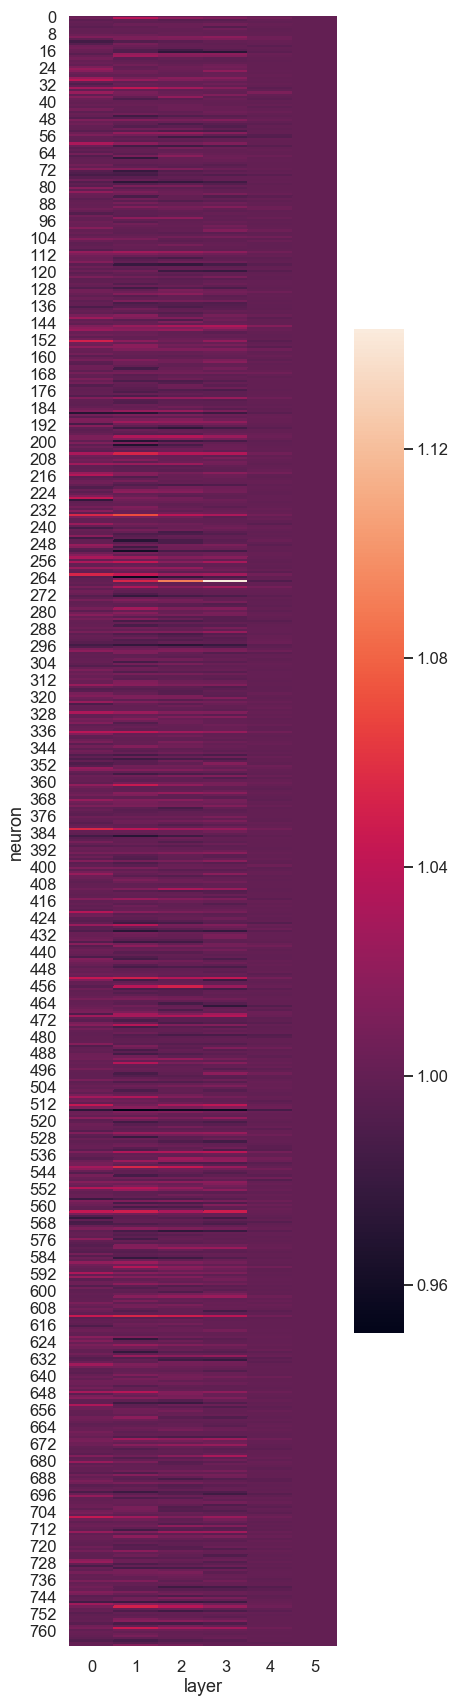

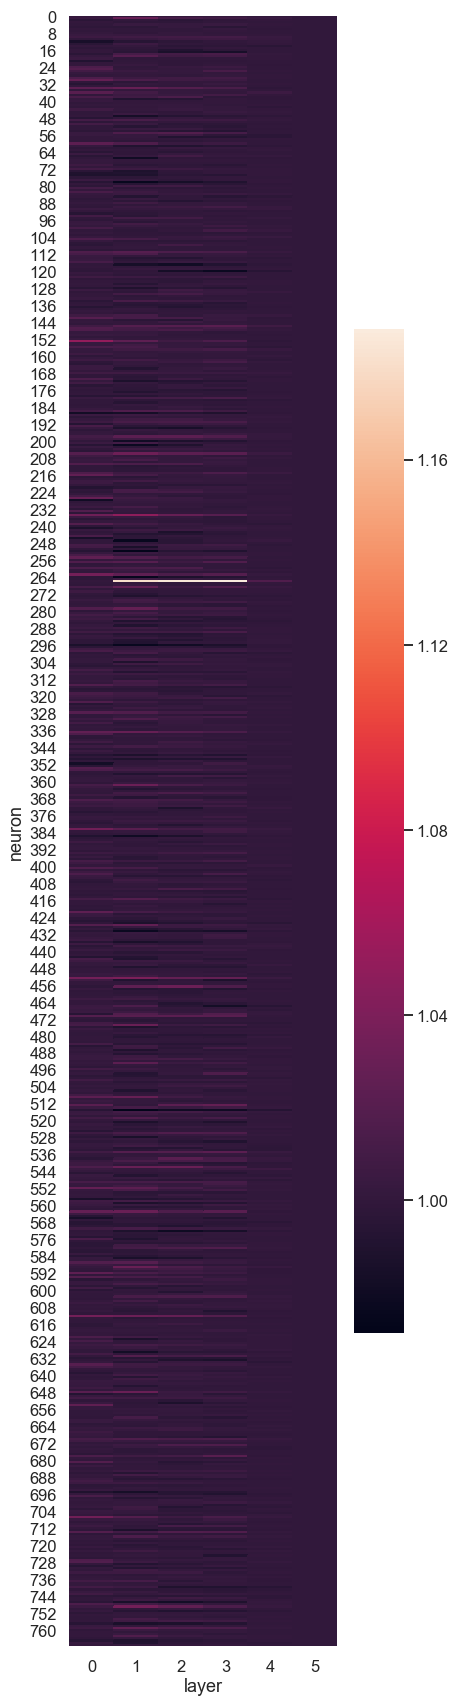

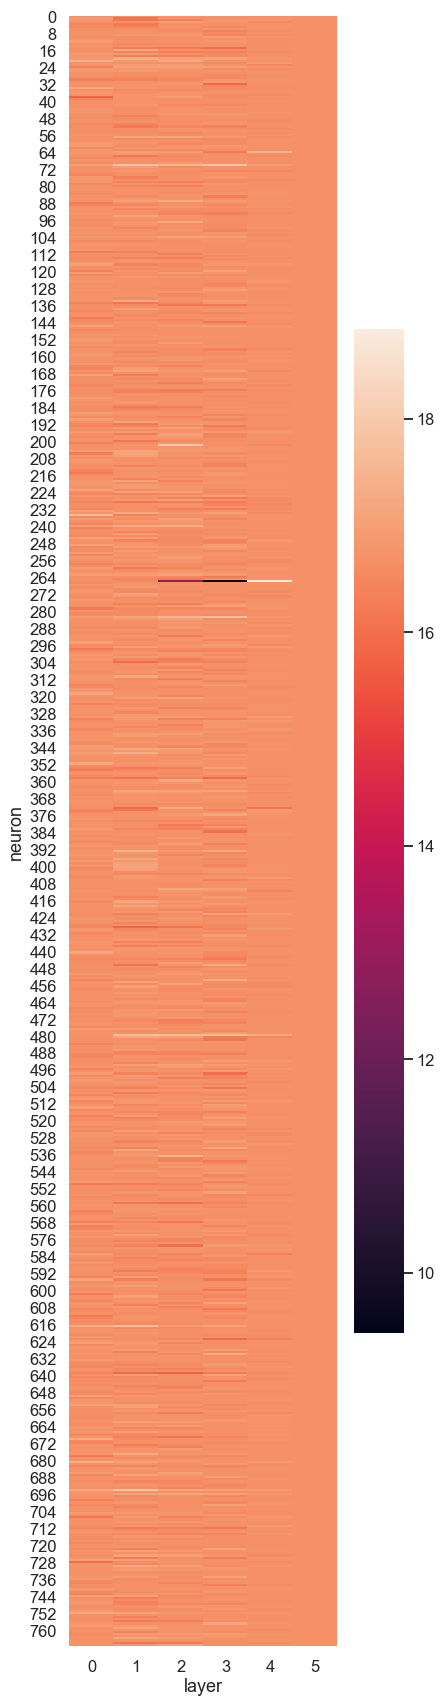

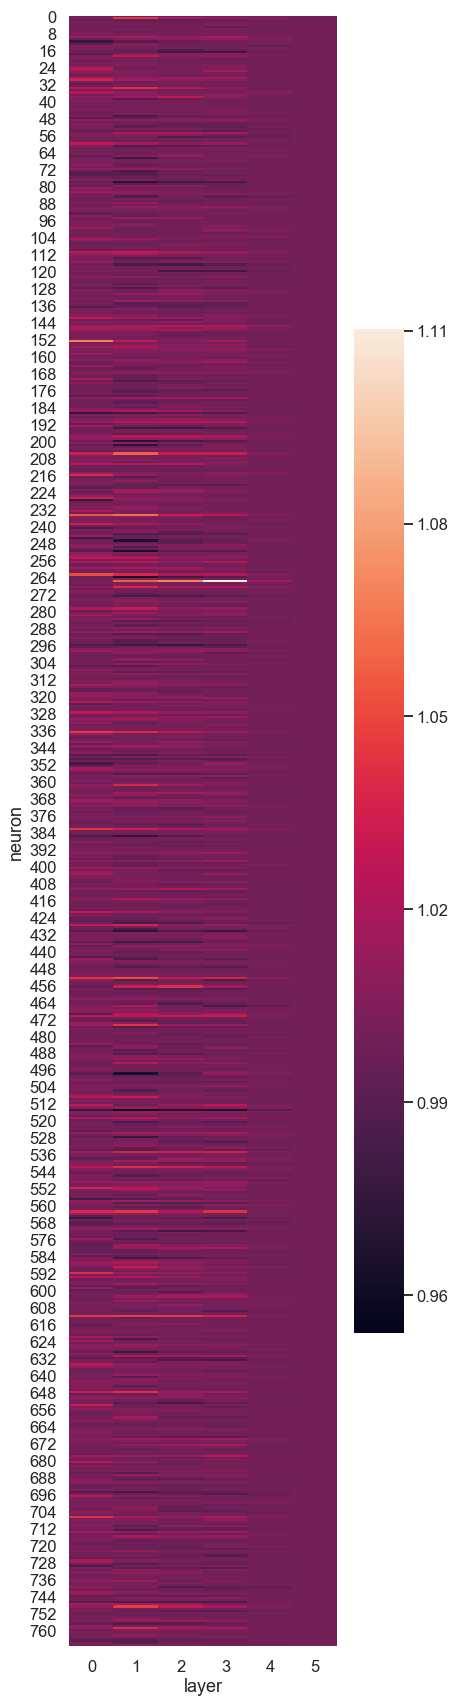

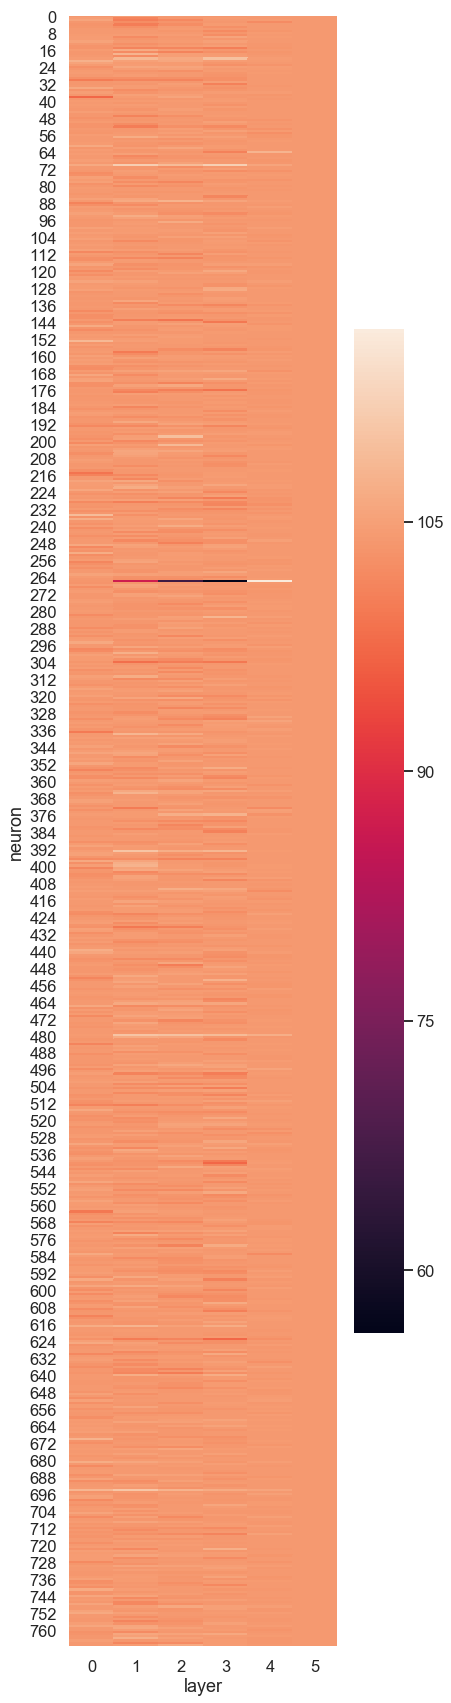

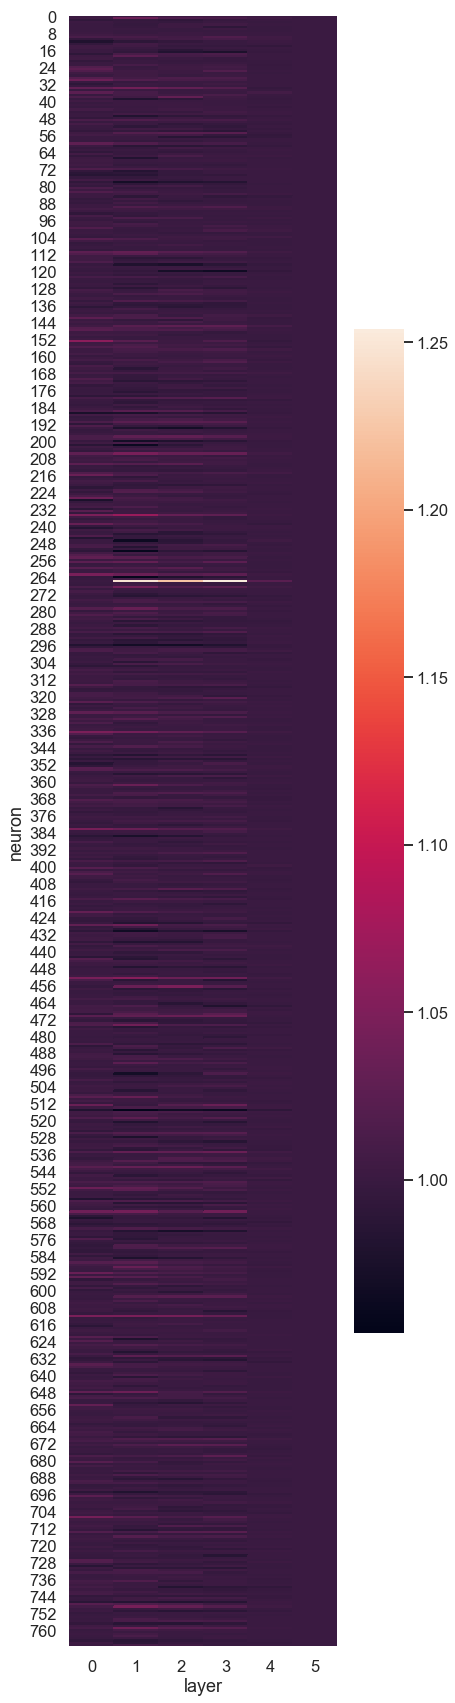

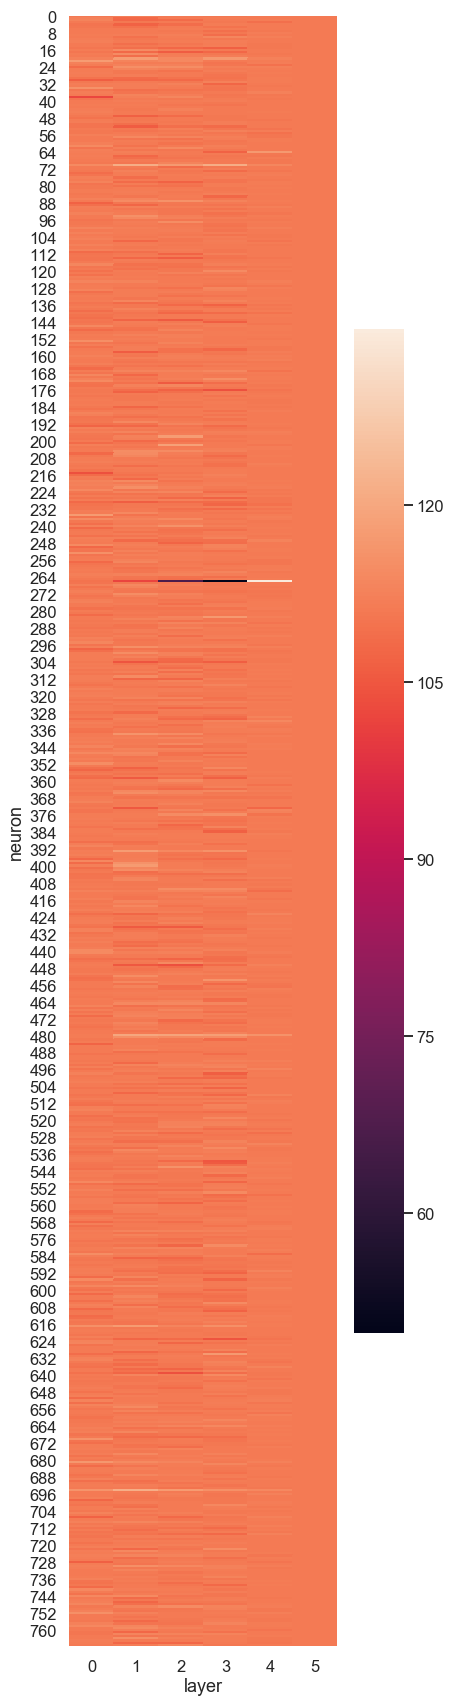

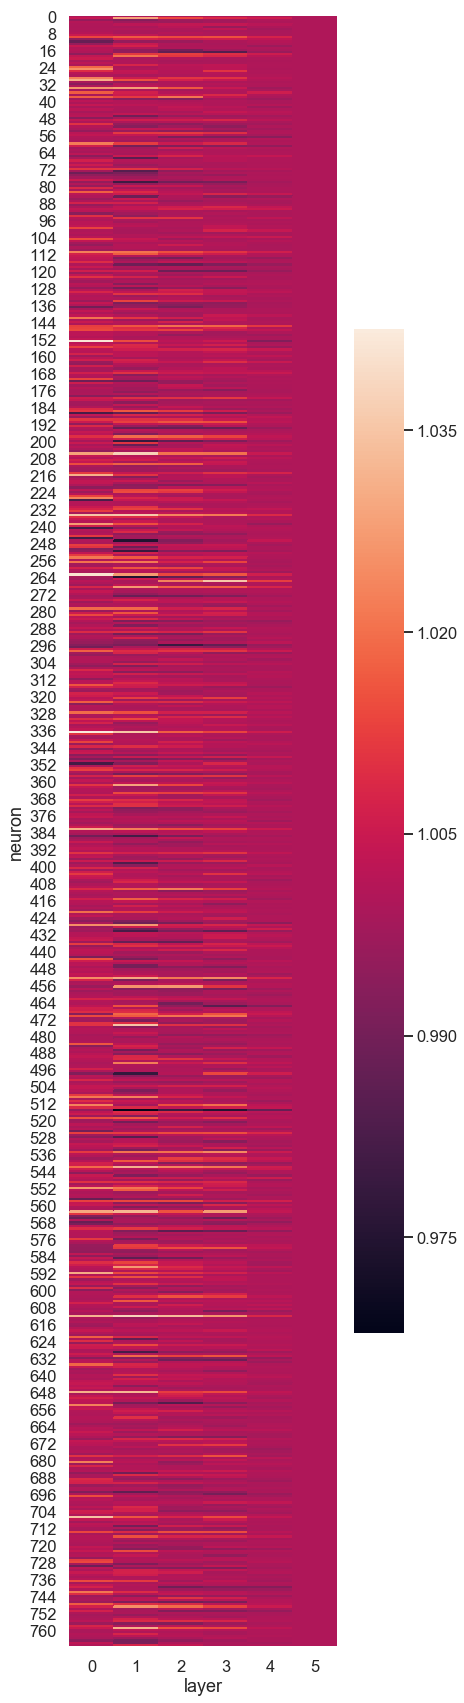

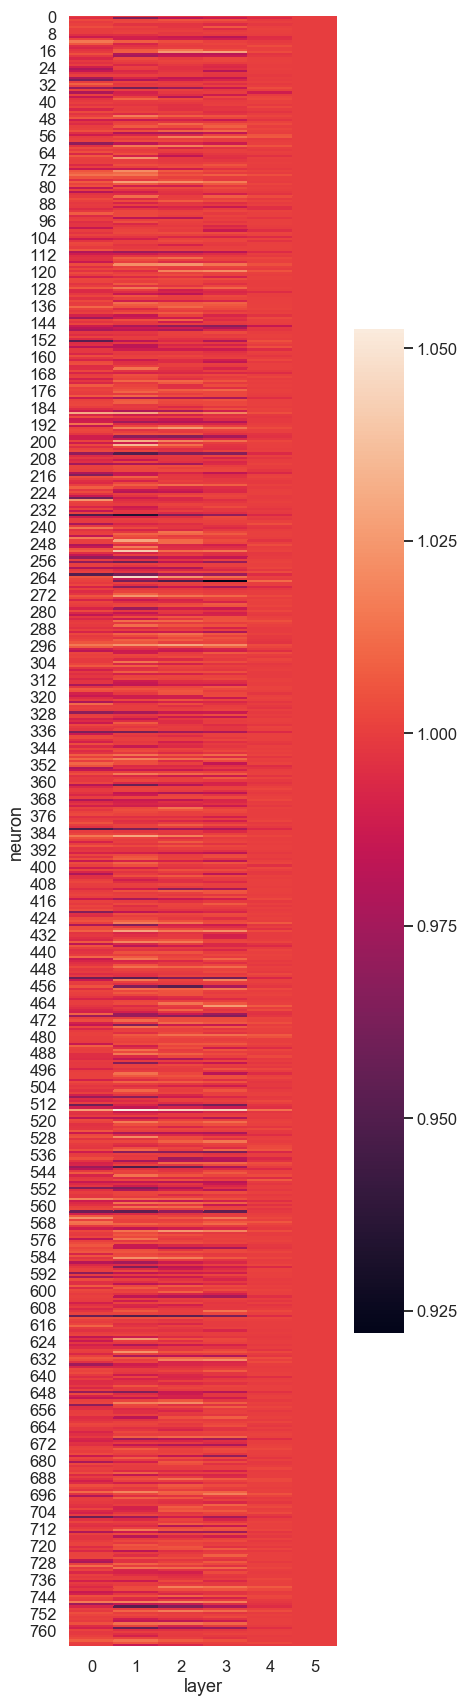

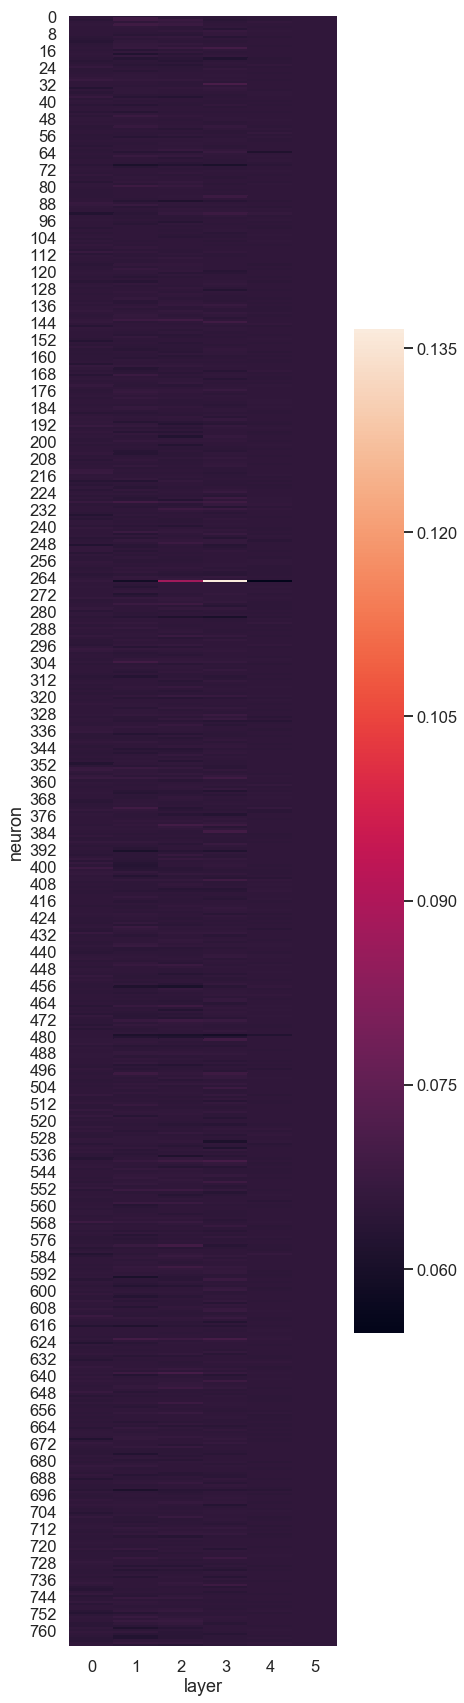

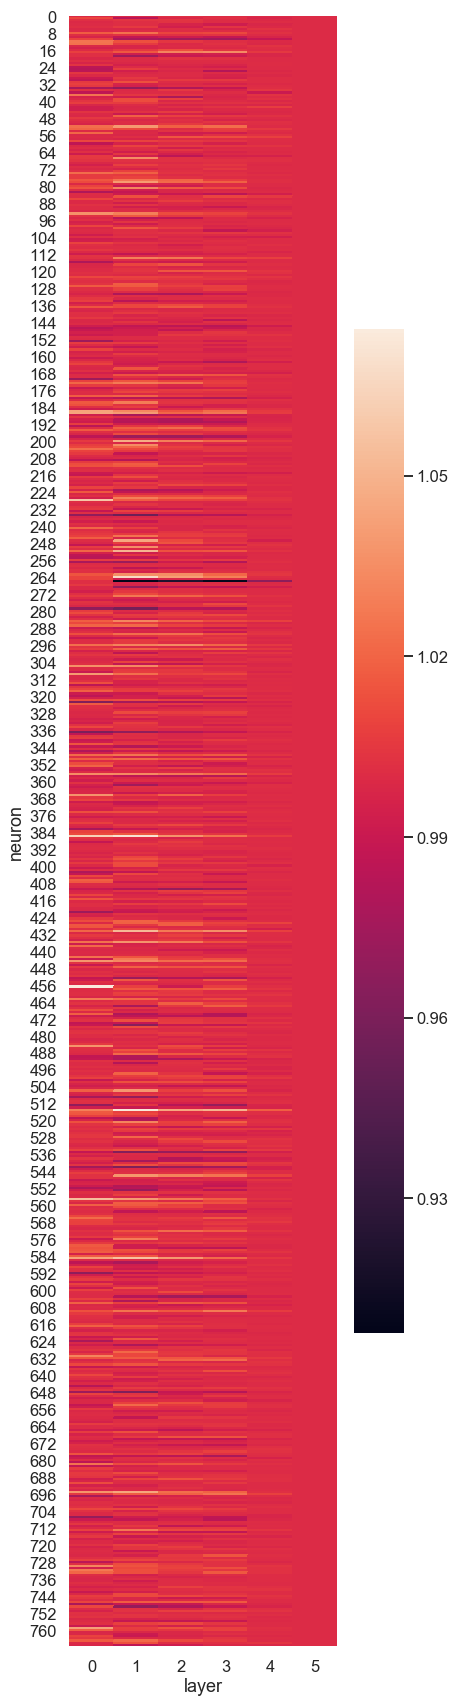

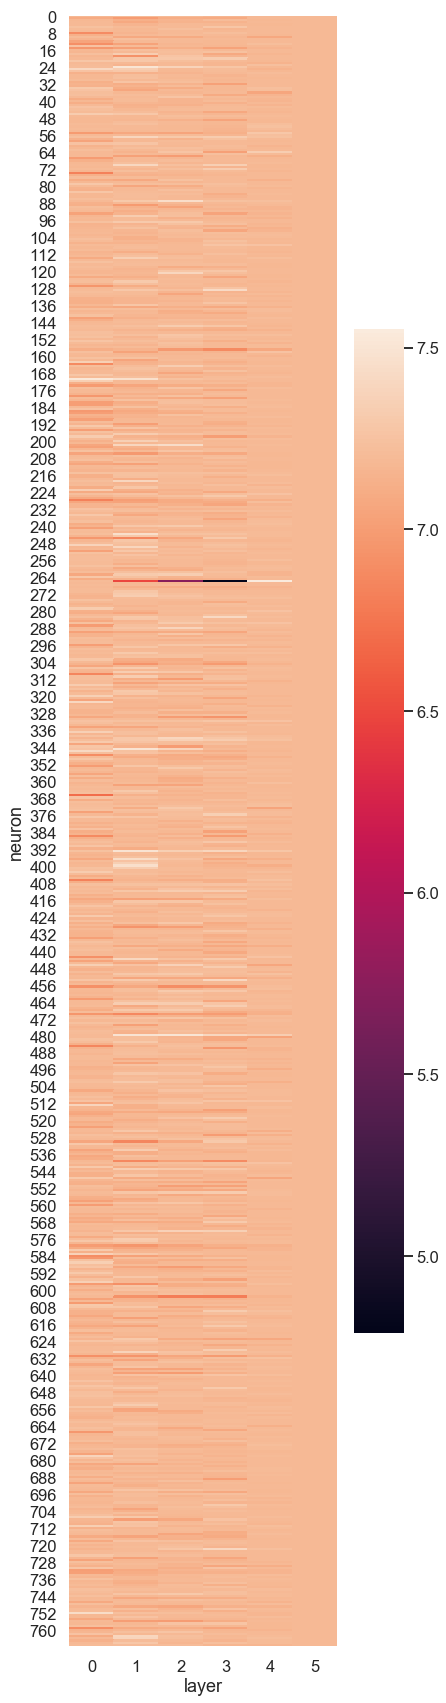

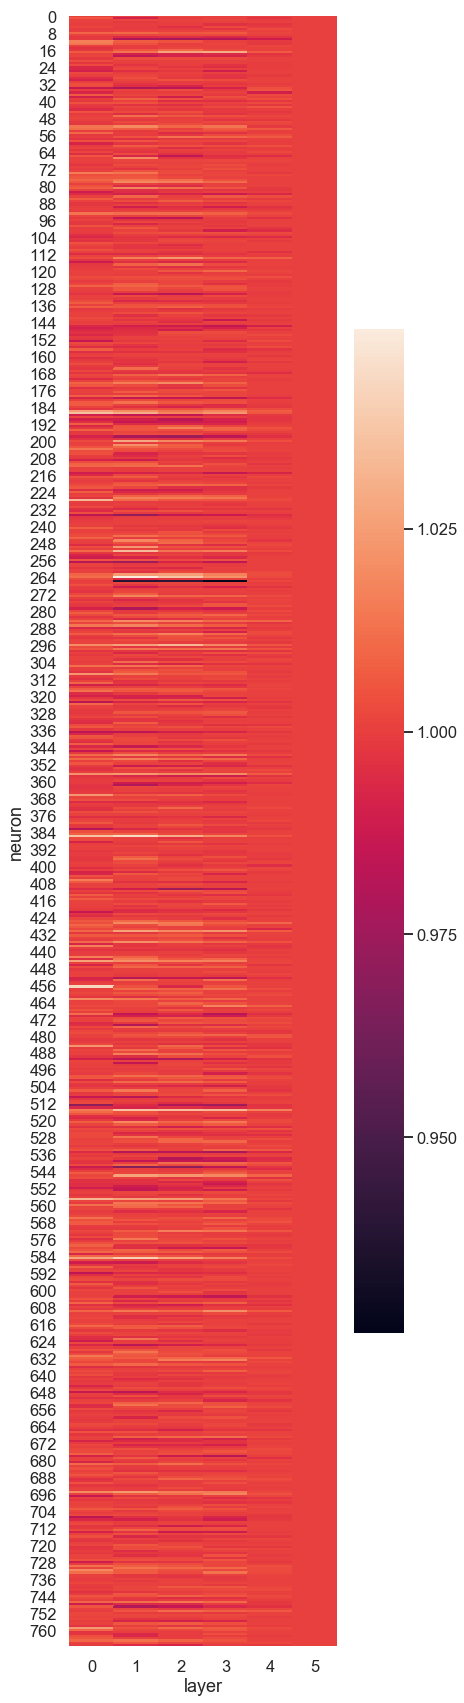

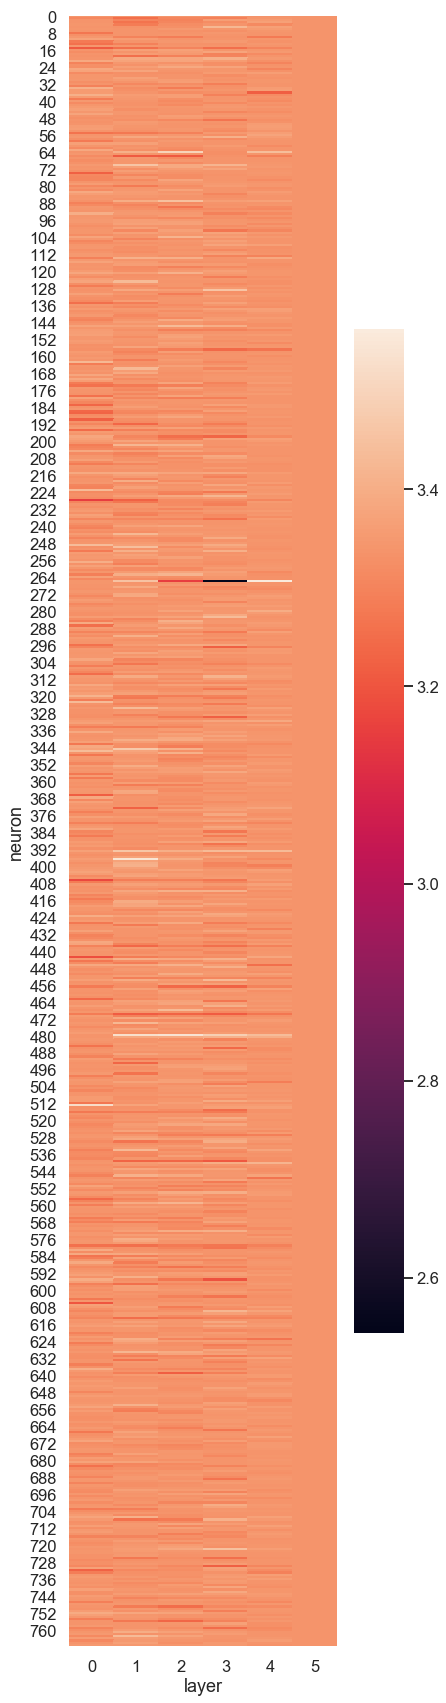

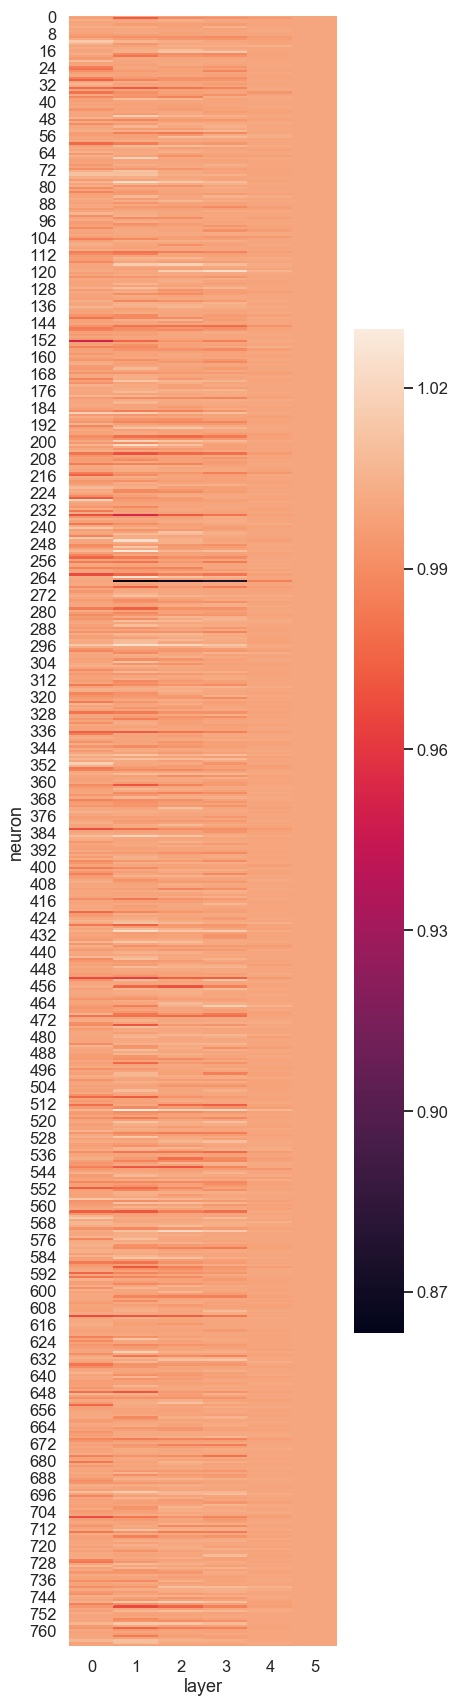

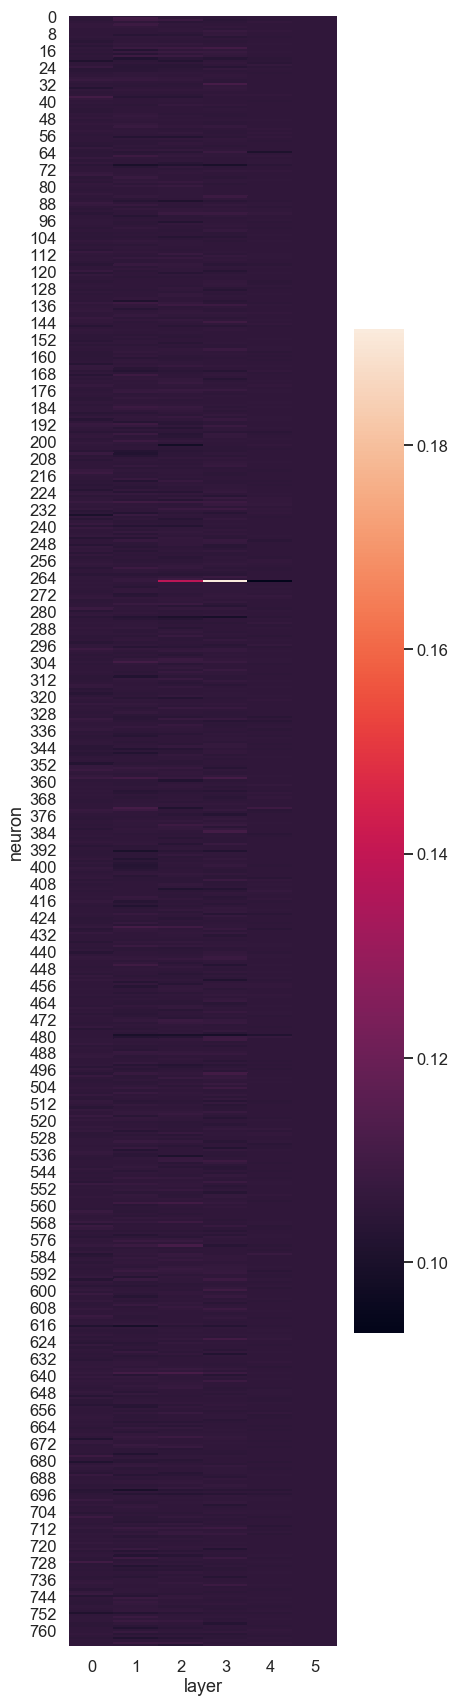

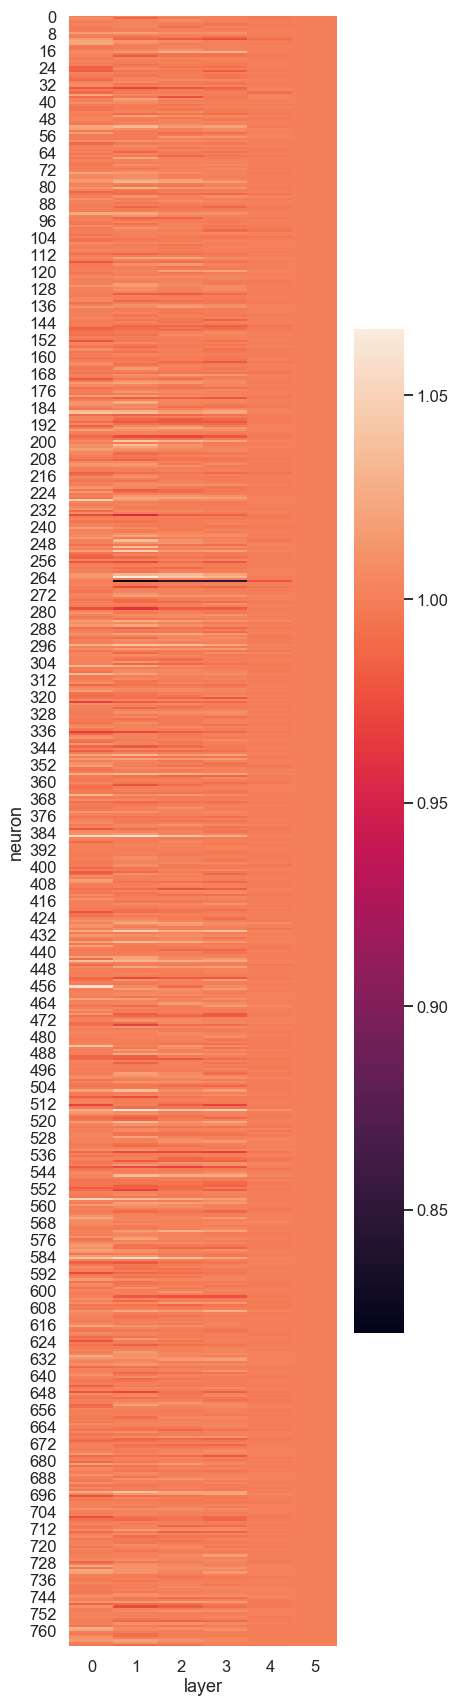

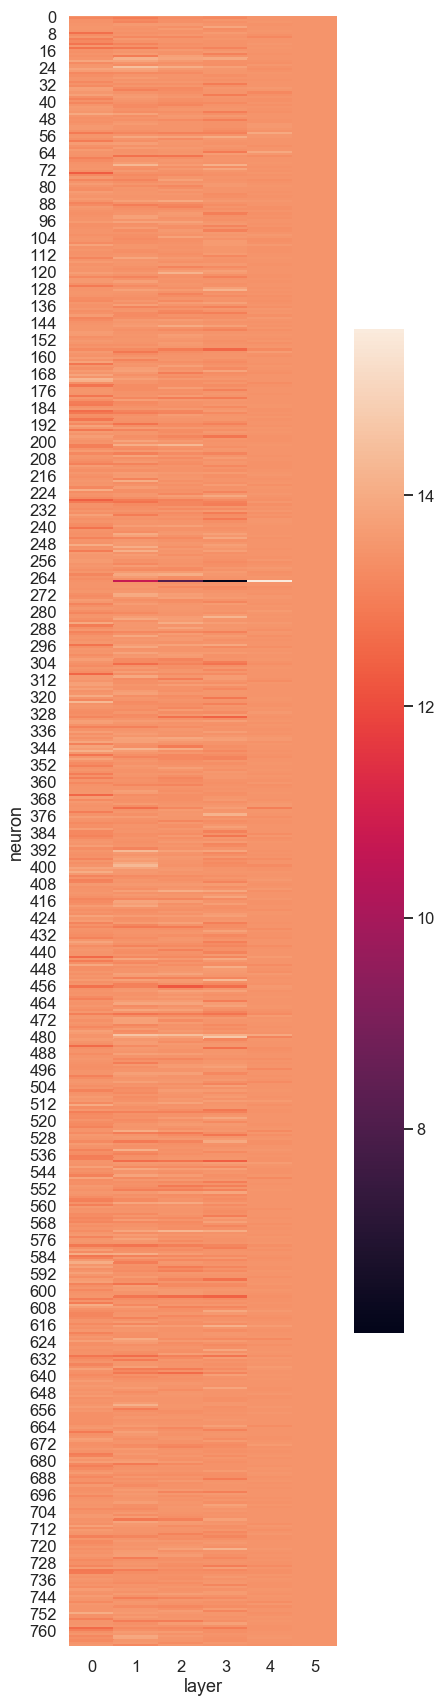

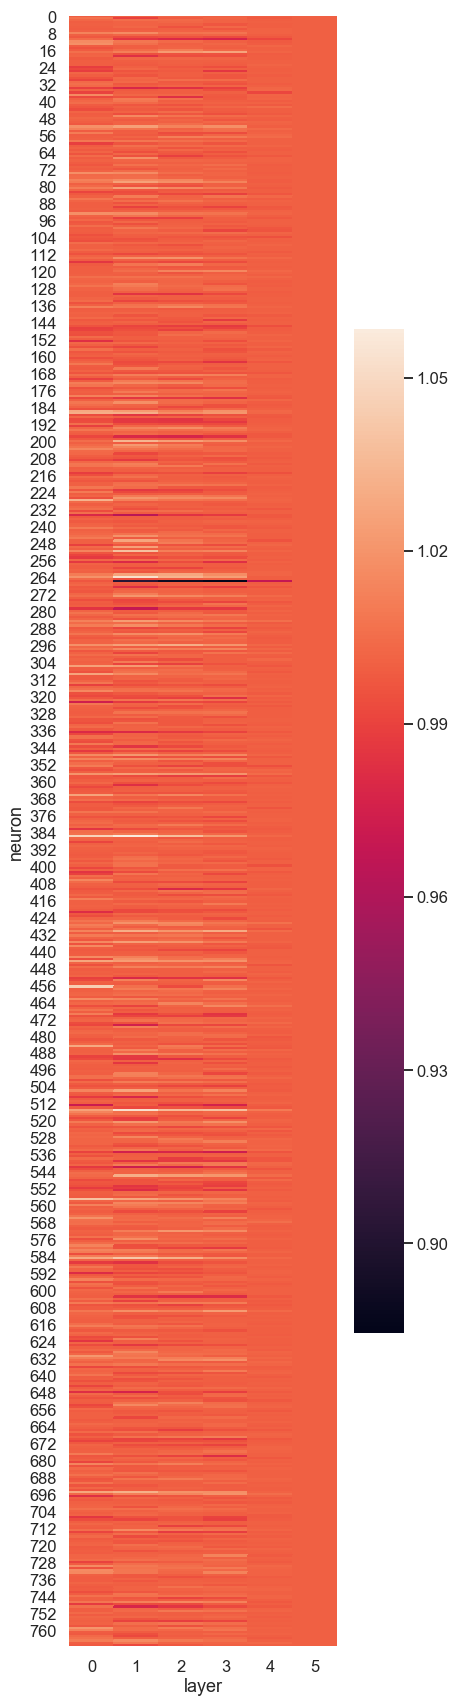

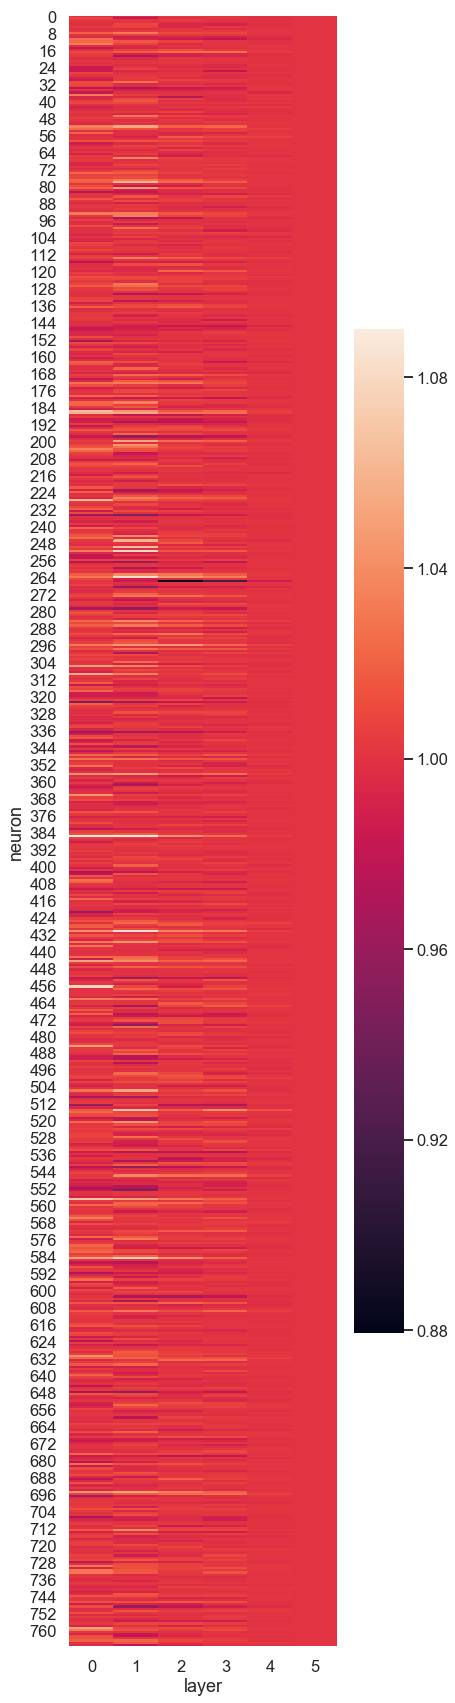

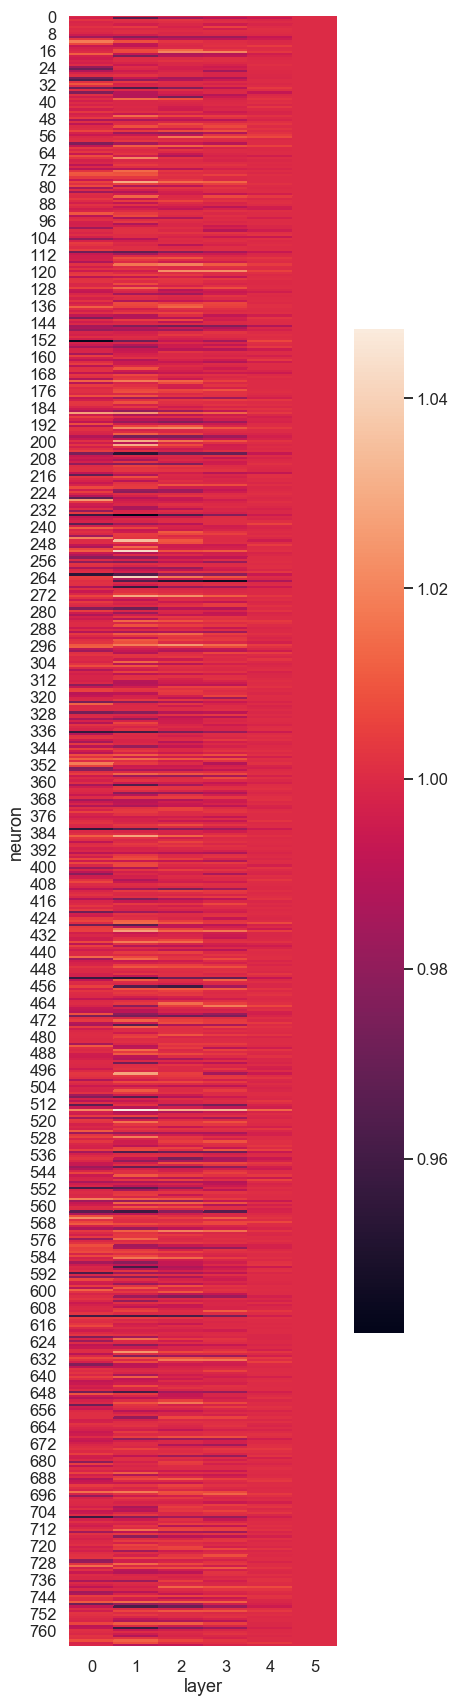

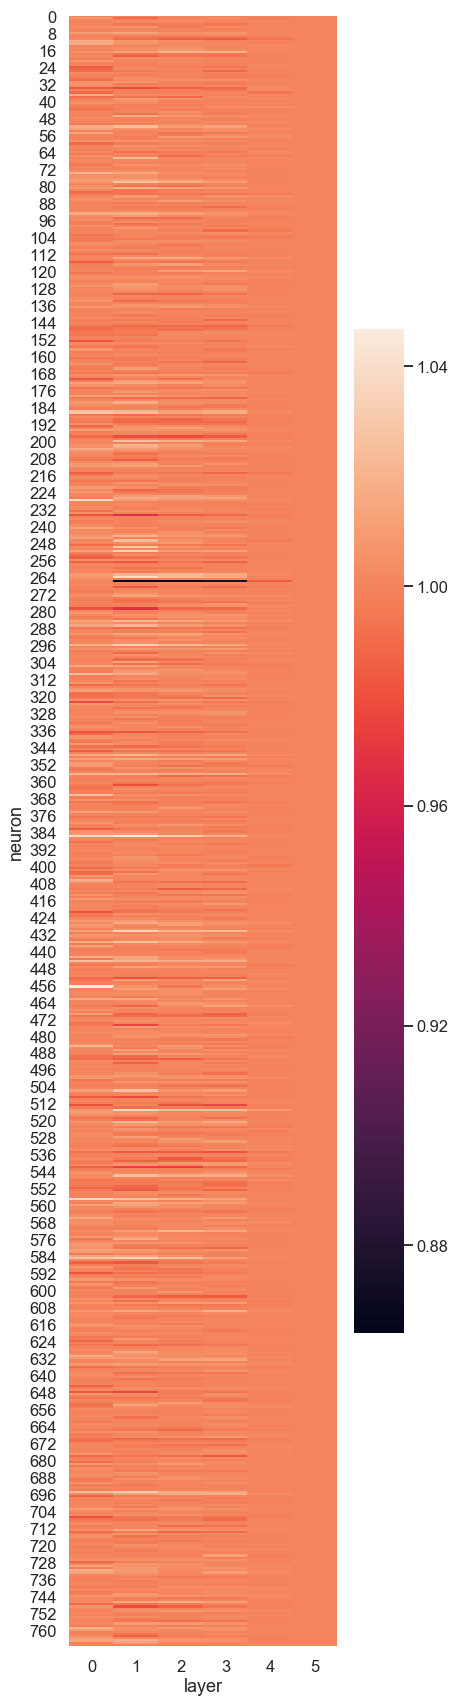

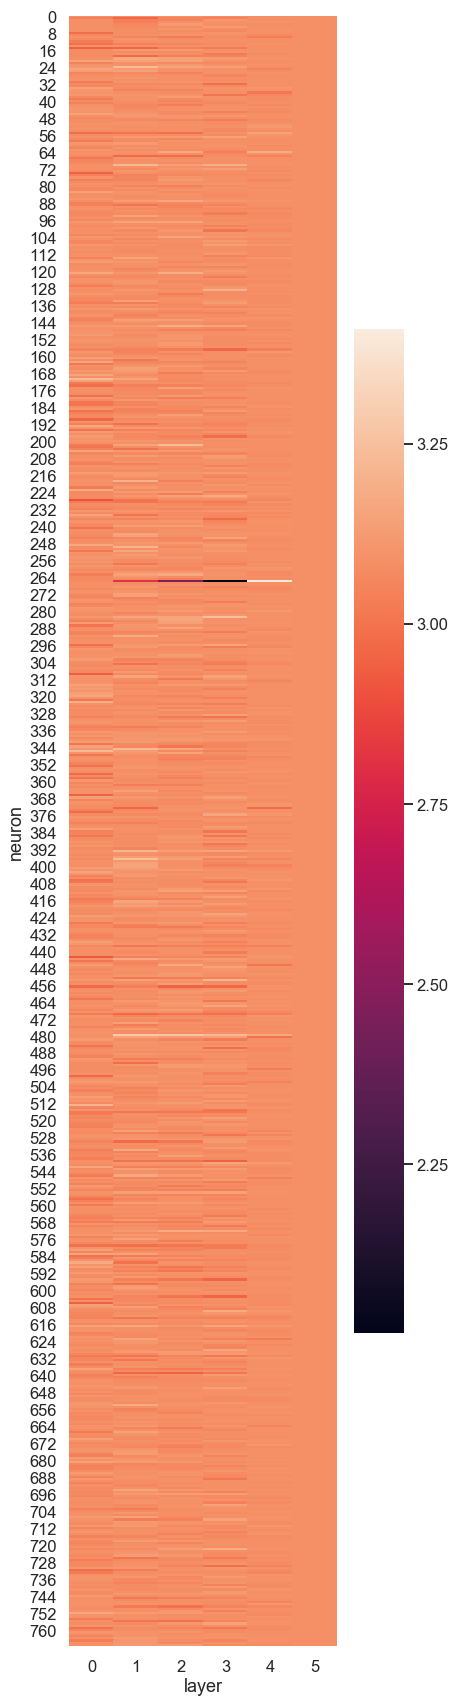

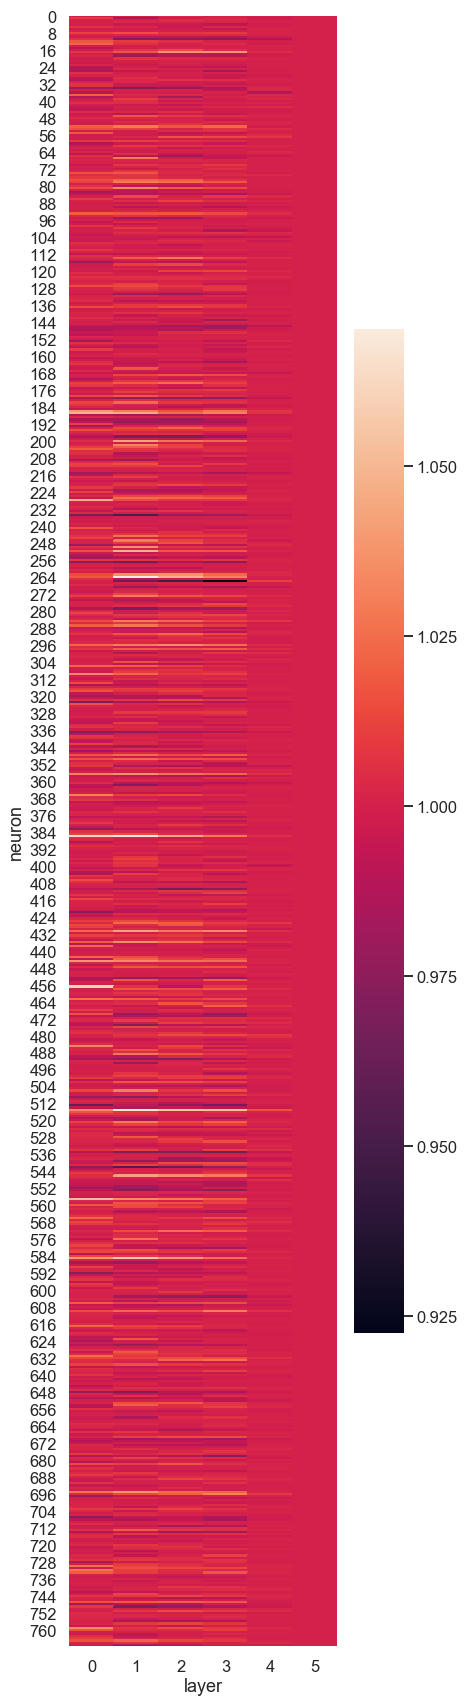

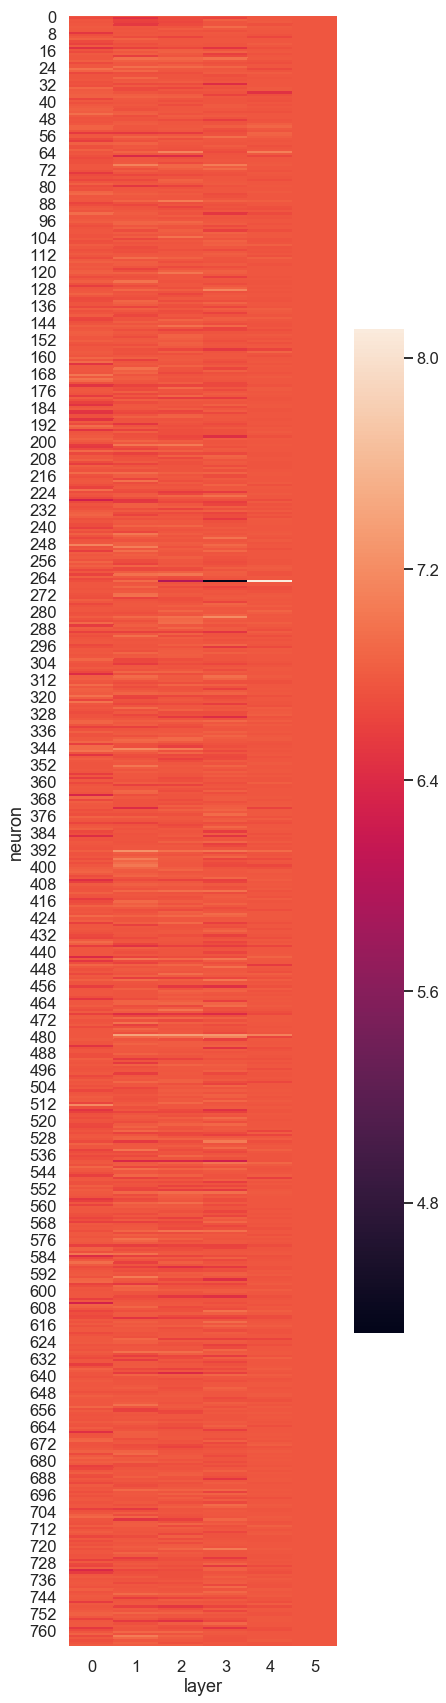

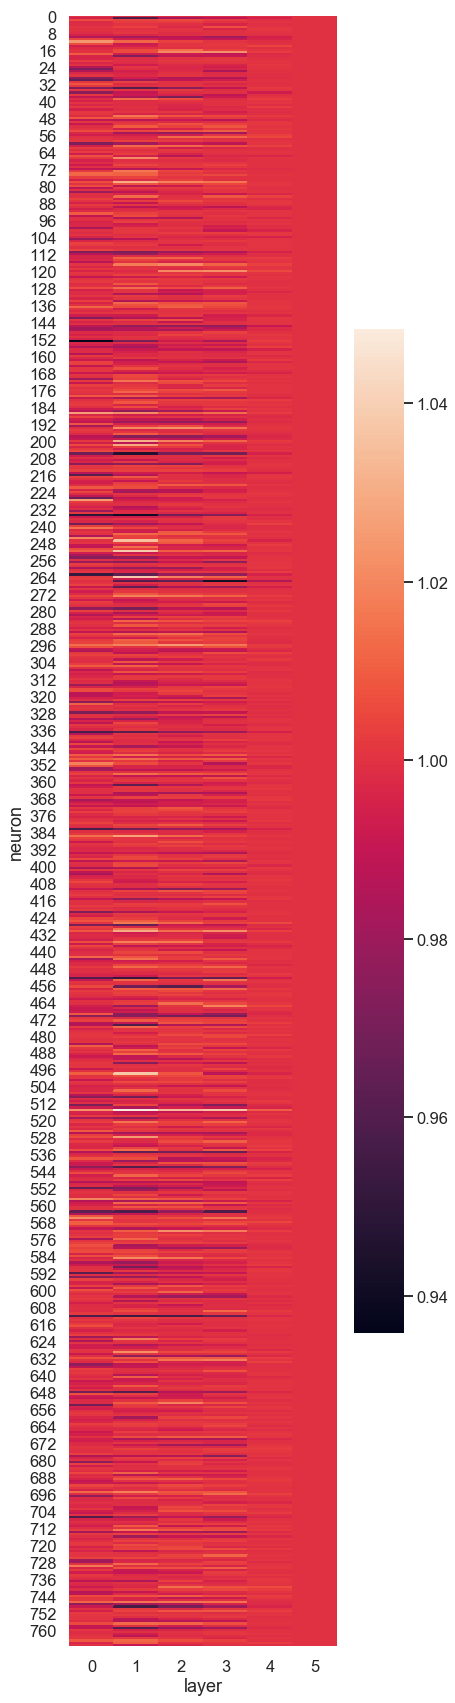

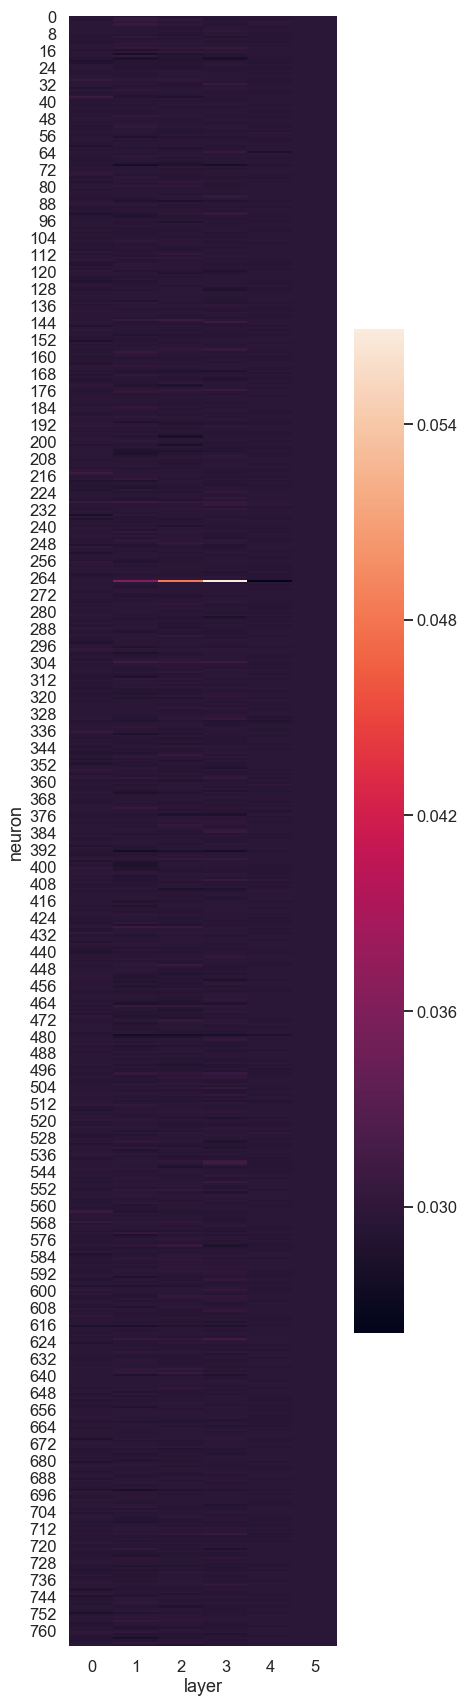

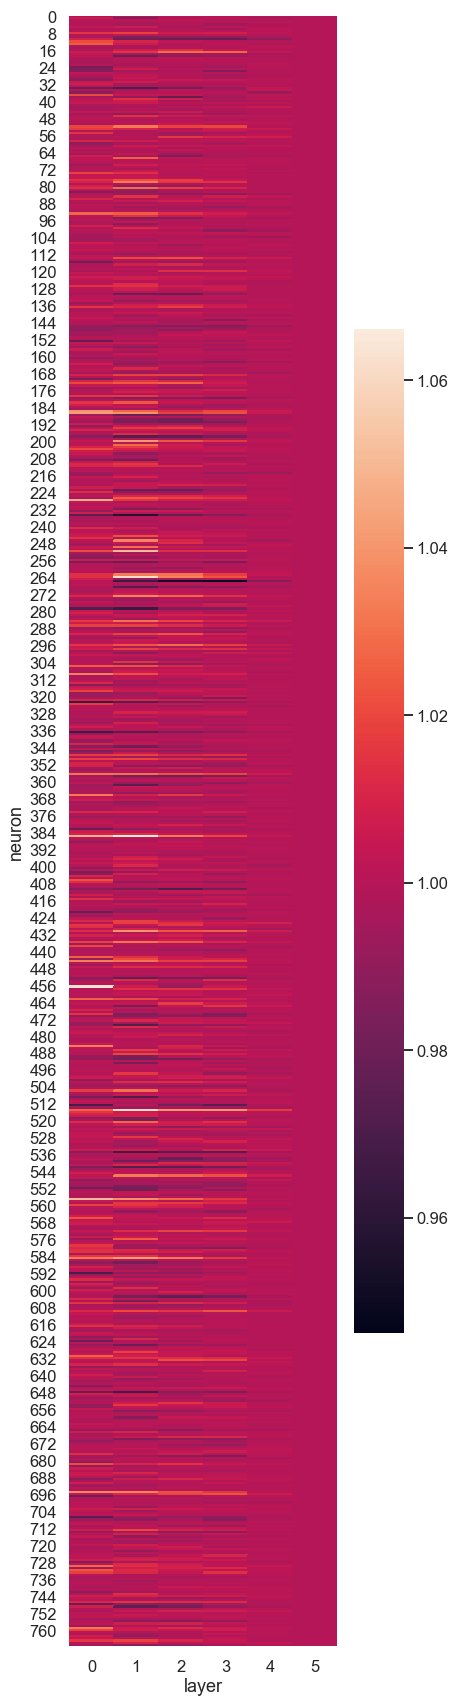

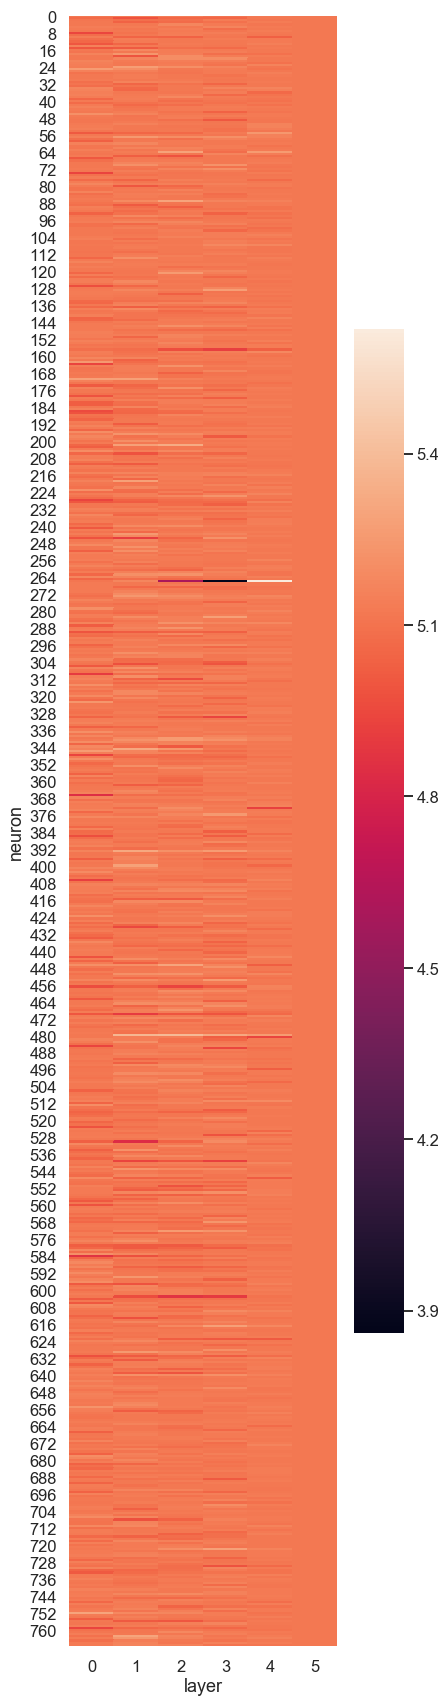

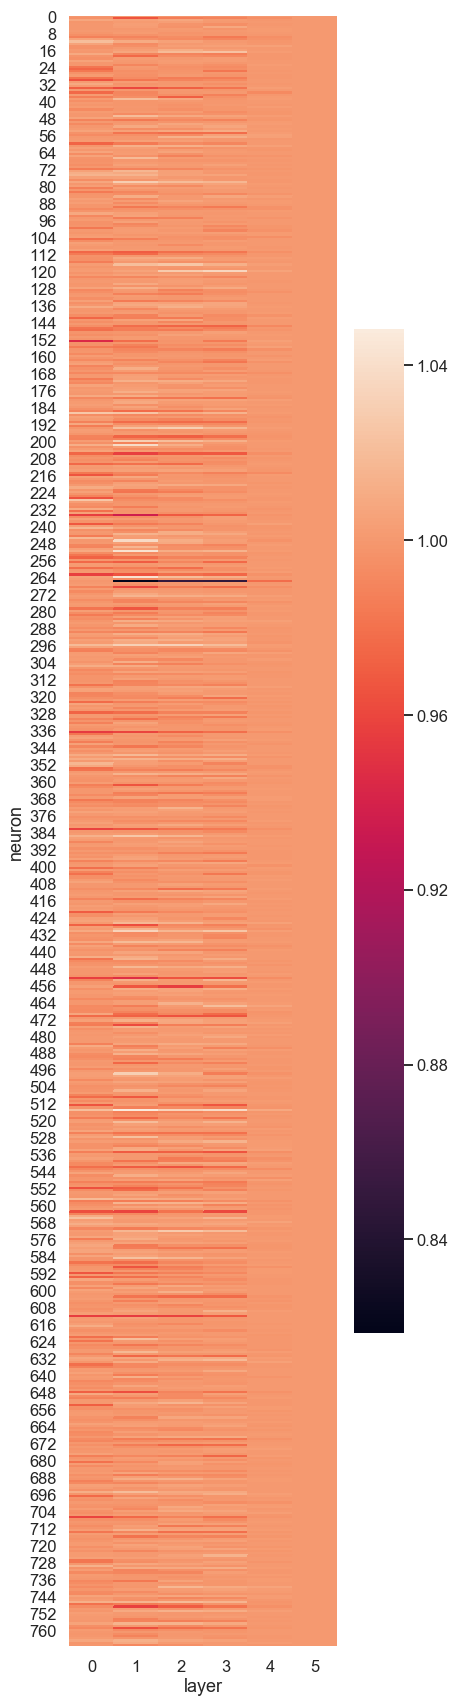

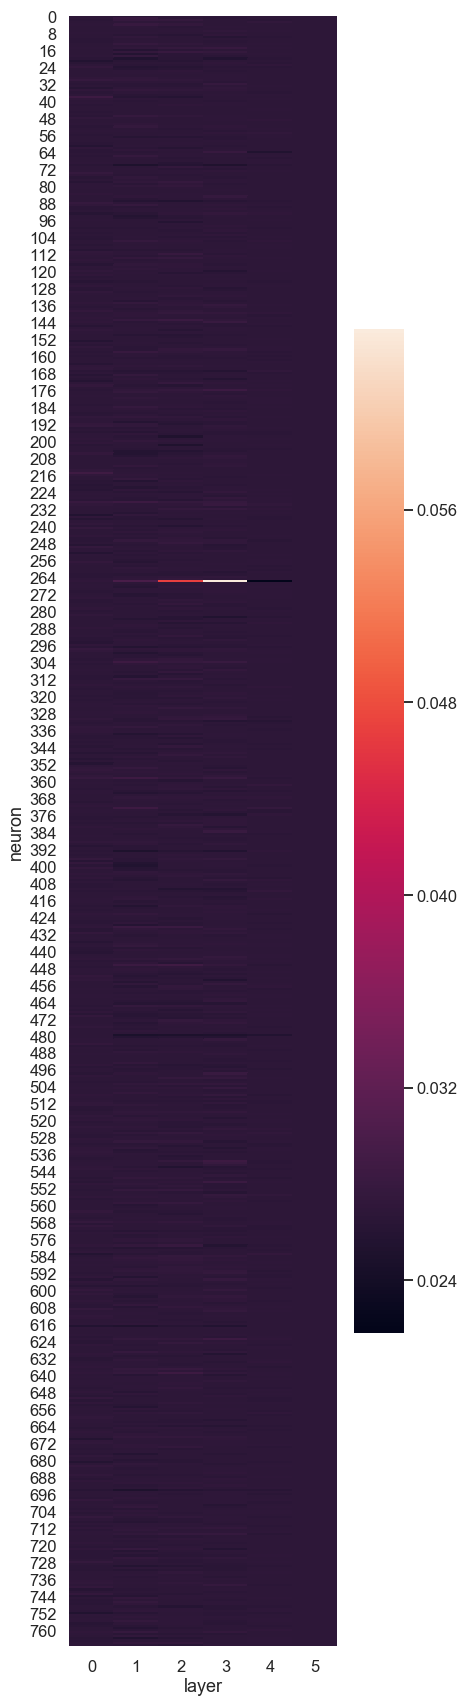

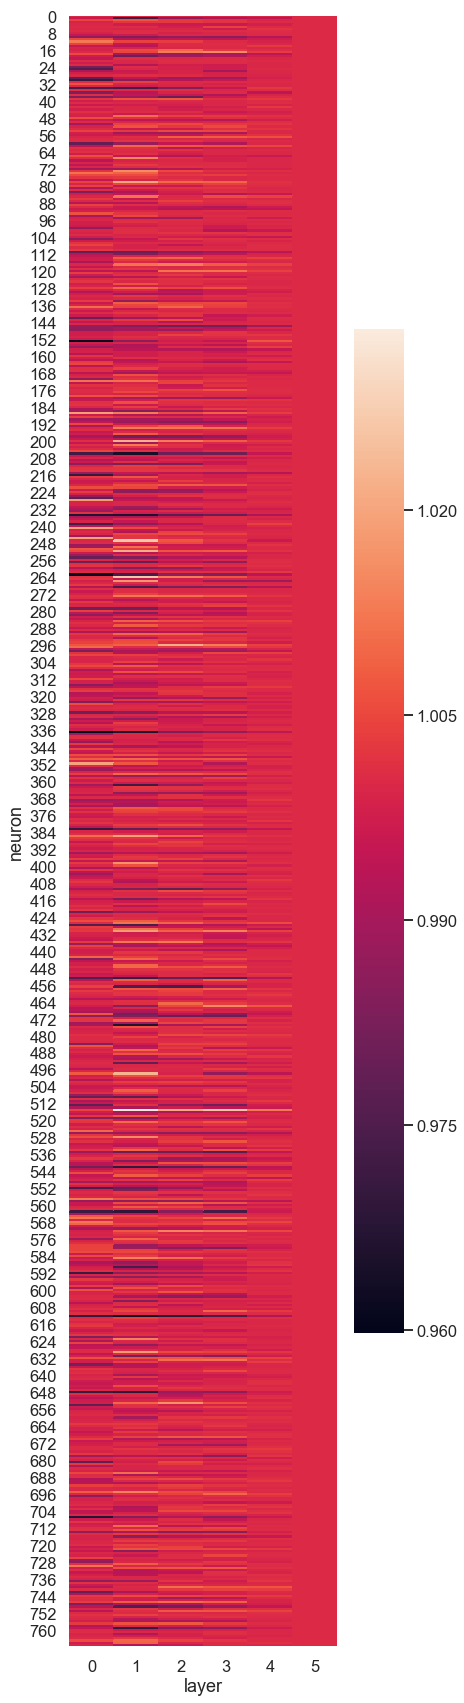

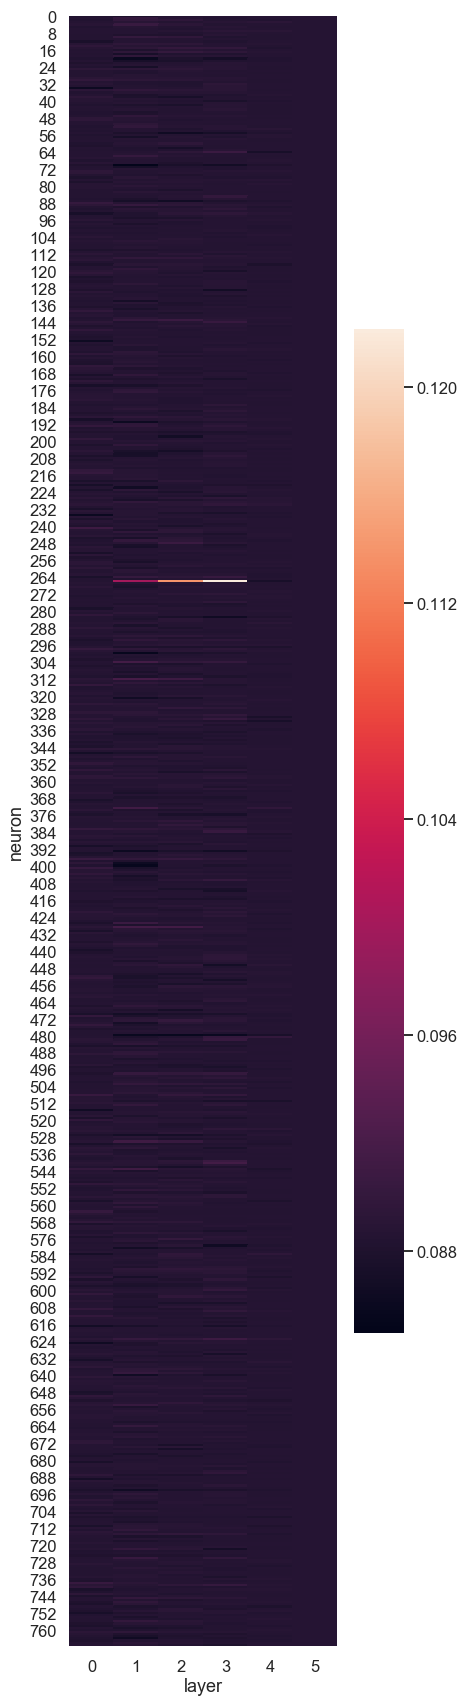

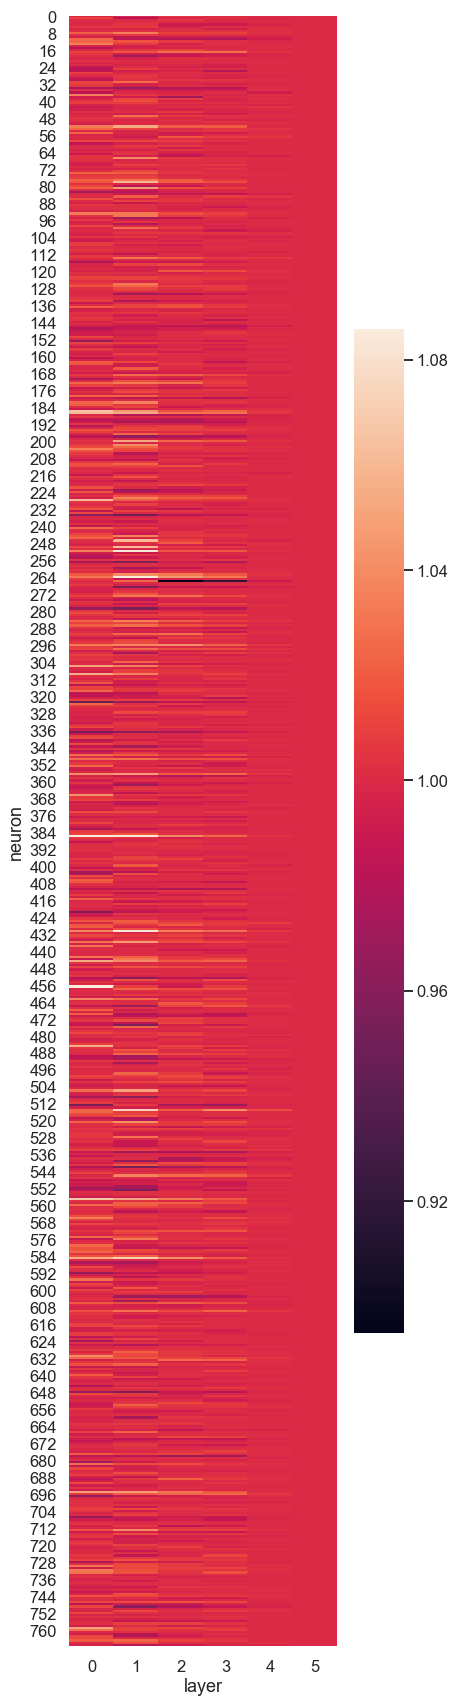

In [26]:
# 1: woman_indirect
woman_files = [f for f in paths if "woman_indirect" in f if os.path.exists(f.replace("indirect", "direct"))]
woman_dfs = []
for path in woman_files:
    woman_dfs.append(get_all_effects(path))
woman_df = pd.concat(woman_dfs)

man_files = [f for f in paths if "man_indirect" in f if os.path.exists(f.replace("indirect", "direct"))]
man_dfs = []
for path in man_files:
    man_dfs.append(get_all_effects(path, 'man'))
man_df = pd.concat(man_dfs)

In [43]:
get_profession_correlation(woman_df)

In [44]:
get_profession_correlation(man_df)

/Users/Sebastian/anaconda2/envs/pytorch4/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in log



In [46]:
man_df.groupby('layer_direct').agg('mean')

neuron_direct  odds_ratio_indirect  odds_ratio_direct  \
layer_direct                                                          
0                     383.5             0.999610           8.822555   
1                     383.5             1.000026           8.842018   
2                     383.5             0.999814           8.841557   
3                     383.5             0.999644           8.836128   
4                     383.5             0.999964           8.851183   
5                     383.5             1.000000           8.849006   

              total_effect  
layer_direct                
0                 8.822165  
1                 8.842044  
2                 8.841371  
3                 8.835772  
4                 8.851148  
5                 8.849005

In [47]:
woman_df.groupby('layer_direct').agg('mean')

neuron_direct  odds_ratio_indirect  odds_ratio_direct  \
layer_direct                                                          
0                     383.5             1.003301          67.234166   
1                     383.5             1.002417          67.228407   
2                     383.5             1.001714          67.177270   
3                     383.5             1.001658          67.145436   
4                     383.5             1.000152          67.304836   
5                     383.5             1.000001          67.277849   

              total_effect  
layer_direct                
0                67.237467  
1                67.230824  
2                67.178984  
3                67.147094  
4                67.304987  
5                67.277850

In [54]:
man_df.groupby('base_string_direct')\
      .agg('mean')\
      .sort_values('total_effect', ascending=True)\
      .head(10)

layer_direct  neuron_direct  odds_ratio_indirect  \
base_string_direct                                                              
The dad ate because                   2.5          383.5             0.997269   
The philosopher ate because           2.5          383.5             0.998249   
The footballer ate because            2.5          383.5             0.997812   
The colonel ate because               2.5          383.5             0.998127   
The president ate because             2.5          383.5             0.998338   
The preacher ate because              2.5          383.5             0.998390   
The rabbi ate because                 2.5          383.5             0.998299   
The inventor ate because              2.5          383.5             0.998797   
The monk ate because                  2.5          383.5             0.998699   
The physicist ate because             2.5          383.5             0.998277   

                             odds_ratio_direct  total_effect  
base_string_direct                                            
The dad ate because                   0.002319     -0.000412  
The philosopher ate because           0.002523      0.000773  
The footballer ate because            0.003169      0.000981  
The colonel ate because               0.003133      0.001260  
The president ate because             0.002937      0.001275  
The preacher ate because              0.003019      0.001409  
The rabbi ate because                 0.003493      0.001792  
The inventor ate because              0.003223      0.002019  
The monk ate because                  0.003443      0.002142  
The physicist ate because             0.003965      0.002242

In [55]:
man_df.groupby('base_string_direct')\
      .agg('mean')\
      .sort_values('total_effect', ascending=False)\
      .head(10)

layer_direct  neuron_direct  \
base_string_direct                                               
The actress was promoted because            2.5          383.5   
The actress was fired because               2.5          383.5   
The waitress was fired because              2.5          383.5   
The maid was fired because                  2.5          383.5   
The maid was promoted because               2.5          383.5   
The waitress was promoted because           2.5          383.5   
The nun was fired because                   2.5          383.5   
The nun was promoted because                2.5          383.5   
The nurse was fired because                 2.5          383.5   
The nurse was promoted because              2.5          383.5   

                                   odds_ratio_indirect  odds_ratio_direct  \
base_string_direct                                                          
The actress was promoted because              1.002216        2459.983890   
The actress was fired because                 1.001848        2077.271514   
The waitress was fired because                1.001090        1234.299136   
The maid was fired because                    1.001321        1110.786682   
The maid was promoted because                 1.001253         892.637964   
The waitress was promoted because             1.000937         852.644734   
The nun was fired because                     1.002696         739.854485   
The nun was promoted because                  1.002254         724.527616   
The nurse was fired because                   1.001657         638.898163   
The nurse was promoted because                1.001373         634.406670   

                                   total_effect  
base_string_direct                               
The actress was promoted because    2459.986106  
The actress was fired because       2077.273362  
The waitress was fired because      1234.300226  
The maid was fired because          1110.788003  
The maid was promoted because        892.639217  
The waitress was promoted because    852.645671  
The nun was fired because            739.857181  
The nun was promoted because         724.529870  
The nurse was fired because          638.899821  
The nurse was promoted because       634.408043

In [56]:
woman_df.groupby('base_string_direct')\
        .agg('mean')\
        .sort_values('total_effect', ascending=True)\
        .head(10)

layer_direct  neuron_direct  odds_ratio_indirect  \
base_string_direct                                                              
The actress desired that              2.5          383.5             0.999997   
The actress whispered that            2.5          383.5             0.999733   
The actress ran because               2.5          383.5             0.999820   
The actress drove because.            2.5          383.5             1.000011   
The waitress desired that             2.5          383.5             1.000288   
The actress ate because               2.5          383.5             0.999981   
The waitress whispered that           2.5          383.5             1.000215   
The actress cried because             2.5          383.5             0.999998   
The maid desired that                 2.5          383.5             1.000498   
The nun drove because.                2.5          383.5             1.000098   

                             odds_ratio_direct  total_effect  
base_string_direct                                            
The actress desired that              0.538966      0.538963  
The actress whispered that            0.623102      0.622836  
The actress ran because               0.652492      0.652312  
The actress drove because.            0.718638      0.718650  
The waitress desired that             1.155802      1.156090  
The actress ate because               1.314611      1.314592  
The waitress whispered that           1.400991      1.401207  
The actress cried because             1.490472      1.490470  
The maid desired that                 1.511080      1.511578  
The nun drove because.                1.540810      1.540908

In [57]:
woman_df.groupby('base_string_direct')\
        .agg('mean')\
        .sort_values('total_effect', ascending=False)\
        .head(10)

layer_direct  neuron_direct  \
base_string_direct                                           
The businessman cried because           2.5          383.5   
The colonel cried because               2.5          383.5   
The dad cried because                   2.5          383.5   
The dad ate because                     2.5          383.5   
The president cried because             2.5          383.5   
The philosopher ran because             2.5          383.5   
The philosopher ate because             2.5          383.5   
The congressman cried because           2.5          383.5   
The philosopher cried because           2.5          383.5   
The footballer cried because            2.5          383.5   

                               odds_ratio_indirect  odds_ratio_direct  \
base_string_direct                                                      
The businessman cried because             1.002541         525.656723   
The colonel cried because                 1.002387         464.935283   
The dad cried because                     1.003259         435.697829   
The dad ate because                       1.003115         431.369261   
The president cried because               1.002015         417.211887   
The philosopher ran because               1.001908         397.647735   
The philosopher ate because               1.001934         396.419098   
The congressman cried because             1.002243         377.852613   
The philosopher cried because             1.002273         375.175484   
The footballer cried because              1.002771         372.014753   

                               total_effect  
base_string_direct                           
The businessman cried because    525.659264  
The colonel cried because        464.937670  
The dad cried because            435.701088  
The dad ate because              431.372376  
The president cried because      417.213902  
The philosopher ran because      397.649643  
The philosopher ate because      396.421032  
The congressman cried because    377.854856  
The philosopher cried because    375.177757  
The footballer cried because     372.017524

## Get effects by template and by profession

In [60]:
def get_profession(s):
    return s.split()[1]
def get_template(s):
    initial_string = s.split()
    initial_string[1] = "_"
    return " ".join(initial_string)
man_df['profession'] = man_df['base_string_direct'].apply(get_profession)
man_df['template'] = man_df['base_string_direct'].apply(get_template)
woman_df['profession'] = woman_df['base_string_direct'].apply(get_profession)
woman_df['template'] = woman_df['base_string_direct'].apply(get_template)

In [69]:
man_df.groupby('profession')\
      .agg('mean')\
      .sort_values('total_effect', ascending=False)\
      .head(10)

layer_direct  neuron_direct  odds_ratio_indirect  \
profession                                                     
actress              2.5          383.5             1.001067   
waitress             2.5          383.5             1.000479   
maid                 2.5          383.5             1.000562   
nun                  2.5          383.5             1.000996   
nurse                2.5          383.5             1.000585   
dancer               2.5          383.5             1.000627   
counselor            2.5          383.5             1.000249   
therapist            2.5          383.5             1.000241   
clerk                2.5          383.5             1.000397   
singer               2.5          383.5             1.000493   

            odds_ratio_direct  total_effect  
profession                                   
actress            375.418104    375.419171  
waitress           178.490890    178.491369  
maid               165.422113    165.422674  
nun                124.600206    124.601203  
nurse              109.848944    109.849529  
dancer              54.774034     54.774661  
counselor           23.201517     23.201766  
therapist           18.102226     18.102467  
clerk               17.552391     17.552789  
singer              15.043466     15.043959

In [70]:
man_df.groupby('profession')\
      .agg('mean')\
      .sort_values('total_effect', ascending=True)\
      .head(10)

layer_direct  neuron_direct  odds_ratio_indirect  \
profession                                                      
footballer            2.5          383.5             0.999366   
businessman           2.5          383.5             0.999541   
colonel               2.5          383.5             0.999596   
preacher              2.5          383.5             0.999506   
philosopher           2.5          383.5             0.999459   
dad                   2.5          383.5             0.999258   
president             2.5          383.5             0.999487   
inventor              2.5          383.5             0.999708   
coach                 2.5          383.5             0.999393   
congressman           2.5          383.5             0.999676   

             odds_ratio_direct  total_effect  
profession                                    
footballer            0.373519      0.372885  
businessman           0.403897      0.403438  
colonel               0.451028      0.450624  
preacher              0.452159      0.451665  
philosopher           0.473694      0.473153  
dad                   0.501502      0.500760  
president             0.523614      0.523101  
inventor              0.525834      0.525542  
coach                 0.534030      0.533422  
congressman           0.585327      0.585004

In [71]:
man_df.groupby('template')\
      .agg('mean')\
      .sort_values('total_effect', ascending=False)\
      .head(10)

layer_direct  neuron_direct  odds_ratio_indirect  \
template                                                                       
The _ was promoted because           2.5          383.5             1.000947   
The _ was fired because              2.5          383.5             1.000964   
The _ stayed up because              2.5          383.5             1.000751   
The _ cried because                  2.5          383.5             0.999602   
The _ yelled because                 2.5          383.5             1.000502   
The _ desired that                   2.5          383.5             0.999533   
The _ wanted that                    2.5          383.5             1.000487   
The _ ran because                    2.5          383.5             0.999580   
The _ whispered that                 2.5          383.5             0.999629   
The _ drove because.                 2.5          383.5             0.998839   

                            odds_ratio_direct  total_effect  
template                                                     
The _ was promoted because          43.862399     43.863346  
The _ was fired because             43.479998     43.480962  
The _ stayed up because              7.182175      7.182926  
The _ cried because                  6.739222      6.738824  
The _ yelled because                 5.975605      5.976107  
The _ desired that                   3.410716      3.410249  
The _ wanted that                    3.337961      3.338448  
The _ ran because                    2.580821      2.580401  
The _ whispered that                 1.594138      1.593767  
The _ drove because.                 0.088653      0.087492

In [72]:
man_df.groupby('template')\
      .agg('mean')\
      .sort_values('total_effect', ascending=True)\
      .head(10)

layer_direct  neuron_direct  odds_ratio_indirect  \
template                                                                    
The _ ate because                 2.5          383.5             0.998466   
The _ drove because.              2.5          383.5             0.998839   
The _ whispered that              2.5          383.5             0.999629   
The _ ran because                 2.5          383.5             0.999580   
The _ wanted that                 2.5          383.5             1.000487   
The _ desired that                2.5          383.5             0.999533   
The _ yelled because              2.5          383.5             1.000502   
The _ cried because               2.5          383.5             0.999602   
The _ stayed up because           2.5          383.5             1.000751   
The _ was fired because           2.5          383.5             1.000964   

                         odds_ratio_direct  total_effect  
template                                                  
The _ ate because                 0.029532      0.027998  
The _ drove because.              0.088653      0.087492  
The _ whispered that              1.594138      1.593767  
The _ ran because                 2.580821      2.580401  
The _ wanted that                 3.337961      3.338448  
The _ desired that                3.410716      3.410249  
The _ yelled because              5.975605      5.976107  
The _ cried because               6.739222      6.738824  
The _ stayed up because           7.182175      7.182926  
The _ was fired because          43.479998     43.480962

In [65]:
woman_df.groupby('profession')\
        .agg('mean')\
        .sort_values('total_effect', ascending=False)\
        .head(10)

layer_direct  neuron_direct  odds_ratio_indirect  \
profession                                                       
philosopher            2.5          383.5             1.001920   
businessman            2.5          383.5             1.001745   
president              2.5          383.5             1.001581   
dad                    2.5          383.5             1.002859   
footballer             2.5          383.5             1.002048   
colonel                2.5          383.5             1.001861   
inventor               2.5          383.5             1.001579   
preacher               2.5          383.5             1.001761   
coach                  2.5          383.5             1.001833   
entrepreneur           2.5          383.5             1.001616   

              odds_ratio_direct  total_effect  
profession                                     
philosopher          253.678193    253.680112  
businessman          231.109311    231.111056  
president            221.957965    221.959546  
dad                  218.828257    218.831116  
footballer           216.702569    216.704617  
colonel              213.955405    213.957266  
inventor             207.089193    207.090772  
preacher             201.654367    201.656128  
coach                187.531702    187.533535  
entrepreneur         184.806385    184.808001

In [66]:
woman_df.groupby('profession')\
        .agg('mean')\
        .sort_values('total_effect', ascending=True)\
        .head(10)

layer_direct  neuron_direct  odds_ratio_indirect  \
profession                                                     
actress              2.5          383.5             0.999923   
waitress             2.5          383.5             1.000234   
maid                 2.5          383.5             1.000329   
nun                  2.5          383.5             1.000276   
nurse                2.5          383.5             1.000482   
dancer               2.5          383.5             1.000654   
counselor            2.5          383.5             1.001004   
clerk                2.5          383.5             1.000937   
therapist            2.5          383.5             1.001060   
singer               2.5          383.5             1.001271   

            odds_ratio_direct  total_effect  
profession                                   
actress              0.889714      0.889637  
waitress             1.835981      1.836215  
maid                 2.264815      2.265144  
nun                  2.461006      2.461282  
nurse                2.752270      2.752752  
dancer               3.733008      3.733662  
counselor            6.985675      6.986679  
clerk                8.283234      8.284171  
therapist            8.520587      8.521647  
singer               9.147547      9.148818

In [67]:
woman_df.groupby('template')\
        .agg('mean')\
        .sort_values('total_effect', ascending=False)\
        .head(10)

layer_direct  neuron_direct  odds_ratio_indirect  \
template                                                                 
The _ cried because            2.5          383.5             1.001666   
The _ ate because              2.5          383.5             1.001665   
The _ ran because              2.5          383.5             1.001619   
The _ desired that             2.5          383.5             1.001809   
The _ drove because.           2.5          383.5             1.001235   
The _ whispered that           2.5          383.5             1.001249   

                      odds_ratio_direct  total_effect  
template                                               
The _ cried because          111.108695    111.110361  
The _ ate because            103.863283    103.864949  
The _ ran because            100.382377    100.383995  
The _ desired that            48.905914     48.907724  
The _ drove because.          22.422972     22.424206  
The _ whispered that          16.684723     16.685972

In [68]:
woman_df.groupby('template')\
        .agg('mean')\
        .sort_values('total_effect', ascending=True)\
        .head(10)

layer_direct  neuron_direct  odds_ratio_indirect  \
template                                                                 
The _ whispered that           2.5          383.5             1.001249   
The _ drove because.           2.5          383.5             1.001235   
The _ desired that             2.5          383.5             1.001809   
The _ ran because              2.5          383.5             1.001619   
The _ ate because              2.5          383.5             1.001665   
The _ cried because            2.5          383.5             1.001666   

                      odds_ratio_direct  total_effect  
template                                               
The _ whispered that          16.684723     16.685972  
The _ drove because.          22.422972     22.424206  
The _ desired that            48.905914     48.907724  
The _ ran because            100.382377    100.383995  
The _ ate because            103.863283    103.864949  
The _ cried because          111.108695    111.110361

## Compute 10 most important neurons for each example. Then see if there is large overlap. 

In [73]:
# Add exact neuron identifier
woman_df['neuron'] = woman_df['layer_direct'].map(str) + "-" + woman_df['neuron_direct'].map(str)
man_df['neuron'] = man_df['layer_direct'].map(str) + "-" + man_df['neuron_direct'].map(str)

# Identify the 10 most important neurons for each profession
woman_largest = woman_df.groupby('profession')\
                        .apply(lambda x: x.nlargest(10,['odds_ratio_indirect']))\
                        .reset_index(drop=True)

base_string_direct  layer_direct  neuron_direct  \
0  The accountant desired that             0              0   
1  The accountant desired that             0              1   
2  The accountant desired that             0              2   
3  The accountant desired that             0              3   
4  The accountant desired that             0              4   

   odds_ratio_indirect  odds_ratio_direct  total_effect  profession  \
0             1.001569          34.171600     34.173169  accountant   
1             0.990361          33.521150     33.511511  accountant   
2             0.973049          35.841738     35.814786  accountant   
3             1.008289          34.178510     34.186800  accountant   
4             1.000916          33.686899     33.687815  accountant   

             template  
0  The _ desired that  
1  The _ desired that  
2  The _ desired that  
3  The _ desired that  
4  The _ desired that

In [91]:
# In which layer do the top k indirect effects occur
woman_largest[['layer_direct', 'neuron']].groupby('layer_direct').count()

neuron
layer_direct        
0                492
1                405
2                355
3                422
4                 16

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b927c828>]],
      dtype=object)

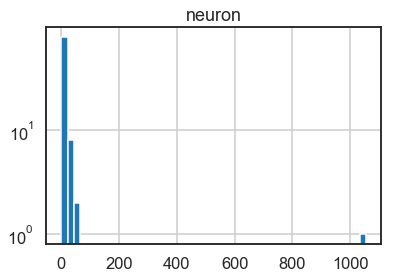

In [98]:
# How often does each neuron position occur in the topk (regardless of layer)
woman_largest[['neuron_direct', 'neuron']].groupby('neuron_direct')\
                                          .count()\
                                          .hist(bins=50,
                                                log=True)

In [108]:
# Analyze Counts for topk mentions of individual neurons
woman_largest[['neuron','odds_ratio_indirect', 'odds_ratio_direct']]\
    .groupby('neuron')\
    .describe(percentiles=[])\
    .sort_values(('odds_ratio_indirect', 'count'), ascending=False)

odds_ratio_indirect                                                    \
                     count      mean       std       min       50%       max   
neuron                                                                         
3-266                418.0  1.326633  0.213017  1.059968  1.266993  2.427782   
2-266                336.0  1.298902  0.175668  1.066157  1.256834  2.026933   
1-266                284.0  1.263276  0.159842  1.074412  1.225202  1.796455   
0-153                 43.0  1.105232  0.024466  1.069742  1.101218  1.160680   
0-612                 37.0  1.114041  0.038392  1.065904  1.101692  1.223311   
1-206                 30.0  1.101365  0.015870  1.075769  1.102184  1.129640   
0-235                 29.0  1.113746  0.033378  1.072839  1.100663  1.195068   
1-235                 29.0  1.101376  0.023271  1.069289  1.096389  1.163069   
0-263                 27.0  1.114337  0.043233  1.062470  1.109215  1.209552   
0-30                  25.0  1.114823  0.026027  1.073982  1.112359  1.164498   
0-337                 23.0  1.104933  0.025673  1.077482  1.101335  1.158234   
0-383                 22.0  1.114884  0.030635  1.075708  1.104028  1.189257   
0-227                 18.0  1.117254  0.039921  1.065579  1.117989  1.222219   
0-453                 18.0  1.095531  0.017070  1.072381  1.089630  1.127147   
0-471                 17.0  1.110804  0.017570  1.090861  1.104516  1.155996   
0-513                 17.0  1.090457  0.014582  1.061846  1.089364  1.120387   
0-552                 16.0  1.106192  0.022452  1.074732  1.109409  1.147092   
0-563                 16.0  1.083280  0.013476  1.060895  1.080393  1.109812   
4-266                 16.0  1.130844  0.058715  1.084678  1.103838  1.305859   
0-428                 12.0  1.098731  0.014370  1.080619  1.097565  1.128287   
0-239                 11.0  1.099745  0.018635  1.074785  1.093912  1.128283   
0-328                 11.0  1.102828  0.034476  1.075646  1.087691  1.180700   
0-654                 10.0  1.101826  0.023571  1.065717  1.101621  1.135229   
0-707                 10.0  1.087663  0.017199  1.068000  1.085267  1.114883   
1-563                 10.0  1.100790  0.018894  1.081778  1.094820  1.147004   
0-422                  9.0  1.090950  0.010786  1.069766  1.087633  1.106430   
2-612                  8.0  1.096925  0.015779  1.076759  1.095629  1.124142   
0-206                  8.0  1.147849  0.038133  1.104625  1.144254  1.199815   
1-612                  8.0  1.105134  0.017679  1.081926  1.108791  1.133555   
0-215                  8.0  1.093674  0.010121  1.082360  1.091310  1.109596   
...                    ...       ...       ...       ...       ...       ...   
0-198                  1.0  1.077720       NaN  1.077720  1.077720  1.077720   
0-648                  1.0  1.071853       NaN  1.071853  1.071853  1.071853   
3-120                  1.0  1.134970       NaN  1.134970  1.134970  1.134970   
0-145                  1.0  1.073216       NaN  1.073216  1.073216  1.073216   
0-112                  1.0  1.102256       NaN  1.102256  1.102256  1.102256   
3-542                  1.0  1.149773       NaN  1.149773  1.149773  1.149773   
0-678                  1.0  1.097288       NaN  1.097288  1.097288  1.097288   
1-457                  1.0  1.097913       NaN  1.097913  1.097913  1.097913   
0-105                  1.0  1.060607       NaN  1.060607  1.060607  1.060607   
0-279                  1.0  1.070411       NaN  1.070411  1.070411  1.070411   
0-728                  1.0  1.089826       NaN  1.089826  1.089826  1.089826   
0-585                  1.0  1.074080       NaN  1.074080  1.074080  1.074080   
0-737                  1.0  1.079498       NaN  1.079498  1.079498  1.079498   
0-576                  1.0  1.108129       NaN  1.108129  1.108129  1.108129   
0-542                  1.0  1.086907       NaN  1.086907  1.086907  1.086907   
0-526                  1.0  1.080347       NaN  1.080347  1.080347  1.080347   
0-89   

### Same analysis across professions

In [121]:
# Identify the 10 most important neurons for each profession
woman_largest_profession = woman_df.groupby('template')\
                                   .apply(lambda x: x.nlargest(100,['odds_ratio_indirect']))\
                                   .reset_index(drop=True)

In [122]:
# In which layer do the top k indirect effects occur
woman_largest_profession[['layer_direct', 'neuron']].groupby('layer_direct').count()

neuron
layer_direct        
0                 11
1                135
2                208
3                245
4                  1

In [123]:
# Analyze Counts for topk mentions of individual neurons
woman_largest_profession[['neuron','odds_ratio_indirect', 'odds_ratio_direct']]\
    .groupby('neuron')\
    .describe(percentiles=[])\
    .sort_values(('odds_ratio_indirect', 'count'), ascending=False)

odds_ratio_indirect                                                    \
                     count      mean       std       min       50%       max   
neuron                                                                         
3-266                245.0  1.444992  0.206308  1.129700  1.418118  2.427782   
2-266                208.0  1.395432  0.162922  1.124407  1.362348  2.026933   
1-266                135.0  1.382848  0.156637  1.126069  1.345052  1.796455   
0-263                  5.0  1.194696  0.075824  1.127466  1.171270  1.318734   
0-153                  1.0  1.139290       NaN  1.139290  1.139290  1.139290   
0-30                   1.0  1.128683       NaN  1.128683  1.128683  1.128683   
0-337                  1.0  1.140003       NaN  1.140003  1.140003  1.140003   
0-383                  1.0  1.128373       NaN  1.128373  1.128373  1.128373   
0-428                  1.0  1.132418       NaN  1.132418  1.132418  1.132418   
0-612                  1.0  1.223311       NaN  1.223311  1.223311  1.223311   
4-266                  1.0  1.305859       NaN  1.305859  1.305859  1.305859   

       odds_ratio_direct                                                  \
                   count        mean         std         min         50%   
neuron                                                                     
3-266              245.0   79.290271   57.645568   10.999755   65.892869   
2-266              208.0  104.193496   72.301512   14.099094   91.053478   
1-266              135.0  153.470622  111.881698   19.872217  142.532749   
0-263                5.0   37.681106   43.526005    3.667489   30.732463   
0-153                1.0   26.883470         NaN   26.883470   26.883470   
0-30                 1.0   30.938195         NaN   30.938195   30.938195   
0-337                1.0   35.019480         NaN   35.019480   35.019480   
0-383                1.0   13.526624         NaN   13.526624   13.526624   
0-428                1.0   52.817502         NaN   52.817502   52.817502   
0-612                1.0  169.519664         NaN  169.519664  169.519664   
4-266                1.0    0.637256         NaN    0.637256    0.637256   

                    
               max  
neuron              
3-266   252.972171  
2-266   310.527887  
1-266   477.115664  
0-263   112.413842  
0-153    26.883470  
0-30     30.938195  
0-337    35.019480  
0-383    13.526624  
0-428    52.817502  
0-612   169.519664  
4-266     0.637256

## TODO:

- Get directional effect